In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor, plot_importance
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import pickle
from sklearn import metrics



In [2]:
usecols = ['game_id', 'user_id', 'bet_id', 'game_type', 'odds', 'fiat_bet_amount',
       'fiat_profit_amount','fiat_is_valuable']


bets_dtypes = {
    'game_id': 'uint32',
    'user_id': 'uint32',
    'bet_id': 'uint64',
    'game_type': 'category',
    'odds': 'float32',
    'fiat_is_valuable': 'category',
    'fiat_bet_amount': 'float32',
    'fiat_profit_amount': 'float32',
}

bets = pd.read_csv("data/bets.csv", usecols=usecols, dtype=bets_dtypes)
bets = bets[bets['fiat_is_valuable'] == 't']


In [3]:
bets.head()


,game_id,user_id,bet_id,game_type,odds,fiat_is_valuable,fiat_bet_amount,fiat_profit_amount
0,2828375,173570,210854317,normal,0.0,t,0.048738,-0.048738
2,2828375,1139219,210854260,normal,2.0,t,0.000088,0.000088
3,2828375,1329183,12148544,yellow,0.0,t,0.188109,-0.188109
4,2828375,1378328,210854292,normal,0.0,t,0.000005,-0.000005
5,2828375,1420292,210854342,normal,3.0,t,0.000107,0.000213


In [4]:
games_usecols = ['game_id', 'max_rate', 'timestamp'] # ,'bet_count']

games_dtypes = {
    'game_id': 'uint32',
    'max_rate': 'float32',
    'timestamp': 'uint32',
    # 'bet_count': 'uint32',
}

games = pd.read_csv("data/games.csv", usecols=games_usecols, dtype=games_dtypes)


In [5]:

games.head()


,game_id,max_rate,timestamp
0,2828375,6.430000,1599622213
1,2828376,2.100000,1599622213
2,2828377,3.110000,1599622213
3,2828378,24.969999,1599622213
4,2828379,1.040000,1599622213


In [6]:
df = pd.merge(bets, games, on='game_id', how='left')
# liberar memória



In [7]:
del bets, games
gc.collect()


0

In [8]:
df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_is_valuable,fiat_bet_amount,fiat_profit_amount,max_rate,timestamp
0,2828375,173570,210854317,normal,0.0,t,0.048738,-0.048738,6.43,1599622213
1,2828375,1139219,210854260,normal,2.0,t,0.000088,0.000088,6.43,1599622213
2,2828375,1329183,12148544,yellow,0.0,t,0.188109,-0.188109,6.43,1599622213
3,2828375,1378328,210854292,normal,0.0,t,0.000005,-0.000005,6.43,1599622213
4,2828375,1420292,210854342,normal,3.0,t,0.000107,0.000213,6.43,1599622213


In [9]:
df.columns


Index(['game_id', 'user_id', 'bet_id', 'game_type', 'odds', 'fiat_is_valuable',
       'fiat_bet_amount', 'fiat_profit_amount', 'max_rate', 'timestamp'],
      dtype='object')

In [10]:
df = df.drop(columns=['fiat_is_valuable'])


In [11]:
# df['total_bet_amount'] = df.groupby('game_id', sort=False)['fiat_bet_amount'].transform('sum')
# df['total_profit_amount'] = df.groupby('game_id', sort=False)['fiat_profit_amount'].transform('sum')



In [12]:
df.head(20)


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,timestamp
0,2828375,173570,210854317,normal,0.00,0.048738,-0.048738,6.43,1599622213
1,2828375,1139219,210854260,normal,2.00,0.000088,0.000088,6.43,1599622213
2,2828375,1329183,12148544,yellow,0.00,0.188109,-0.188109,6.43,1599622213
3,2828375,1378328,210854292,normal,0.00,0.000005,-0.000005,6.43,1599622213
4,2828375,1420292,210854342,normal,3.00,0.000107,0.000213,6.43,1599622213
5,2828375,1205760,12148533,red,0.00,0.000176,-0.000176,6.43,1599622213
6,2828375,1335815,210854336,normal,2.00,0.000008,0.000008,6.43,1599622213
7,2828375,1189902,210854446,normal,5.00,0.000283,0.001131,6.43,1599622213
8,2828375,1378313,210854326,normal,2.00,0.000301,0.000301,6.43,1599622213
9,2828375,1287181,210854358,normal,2.00,0.000019,0.000019,6.43,1599622213


In [13]:
df['saldo'] = df.groupby('user_id')['fiat_profit_amount'].cumsum()
df['n_aposta'] = df.groupby('user_id').cumcount() + 1


In [14]:
conditions = [
    (df['game_type'] == 'normal') & (df['odds'] == 0),
    (df['game_type'] == 'green'),
    (df['game_type'] == 'red'),
    (df['game_type'] == 'yellow')
]

values = [
    df['max_rate'],
    2,
    1.96,
    10
]

df['odds_adjusted'] = np.select(conditions, values, default=df['odds'])


In [15]:
df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,timestamp,saldo,n_aposta,odds_adjusted
0,2828375,173570,210854317,normal,0.0,0.048738,-0.048738,6.43,1599622213,-0.048738,1,6.43
1,2828375,1139219,210854260,normal,2.0,0.000088,0.000088,6.43,1599622213,0.000088,1,2.00
2,2828375,1329183,12148544,yellow,0.0,0.188109,-0.188109,6.43,1599622213,-0.188109,1,10.00
3,2828375,1378328,210854292,normal,0.0,0.000005,-0.000005,6.43,1599622213,-0.000005,1,6.43
4,2828375,1420292,210854342,normal,3.0,0.000107,0.000213,6.43,1599622213,0.000213,1,3.00


In [16]:

# df['user_bet_mean'] = df.groupby('user_id')['fiat_bet_amount'].transform('mean')



In [17]:

df["user_bet_mean_weighted"] = (
    df.groupby("user_id")["fiat_bet_amount"]
      .transform(lambda x: x.ewm(alpha=0.01, adjust=False).mean())
)

df["bet_proportion_weighted"] = df["fiat_bet_amount"] / df["user_bet_mean_weighted"]


In [18]:
df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,timestamp,saldo,n_aposta,odds_adjusted,user_bet_mean_weighted,bet_proportion_weighted
0,2828375,173570,210854317,normal,0.0,0.048738,-0.048738,6.43,1599622213,-0.048738,1,6.43,0.048738,1.0
1,2828375,1139219,210854260,normal,2.0,0.000088,0.000088,6.43,1599622213,0.000088,1,2.00,0.000088,1.0
2,2828375,1329183,12148544,yellow,0.0,0.188109,-0.188109,6.43,1599622213,-0.188109,1,10.00,0.188109,1.0
3,2828375,1378328,210854292,normal,0.0,0.000005,-0.000005,6.43,1599622213,-0.000005,1,6.43,0.000005,1.0
4,2828375,1420292,210854342,normal,3.0,0.000107,0.000213,6.43,1599622213,0.000213,1,3.00,0.000107,1.0


In [19]:
# df['bet_proportion'] = df['fiat_bet_amount'] / df['user_bet_mean']
df.head(2000)


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,timestamp,saldo,n_aposta,odds_adjusted,user_bet_mean_weighted,bet_proportion_weighted
0,2828375,173570,210854317,normal,0.00,4.873766e-02,-4.873766e-02,6.43,1599622213,-4.873766e-02,1,6.43,4.873766e-02,1.000000
1,2828375,1139219,210854260,normal,2.00,8.770193e-05,8.770193e-05,6.43,1599622213,8.770193e-05,1,2.00,8.770193e-05,1.000000
2,2828375,1329183,12148544,yellow,0.00,1.881093e-01,-1.881093e-01,6.43,1599622213,-1.881093e-01,1,10.00,1.881093e-01,1.000000
3,2828375,1378328,210854292,normal,0.00,4.884143e-06,-4.884143e-06,6.43,1599622213,-4.884143e-06,1,6.43,4.884143e-06,1.000000
4,2828375,1420292,210854342,normal,3.00,1.067355e-04,2.134710e-04,6.43,1599622213,2.134710e-04,1,3.00,1.067355e-04,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2828382,1191238,210856737,normal,1.51,4.838508e-06,2.467639e-06,2.51,1599622213,1.001571e-05,8,1.51,9.326494e-06,0.518792
1996,2828382,1357121,210856899,normal,2.25,1.452070e-09,1.815088e-09,2.51,1599622213,2.323312e-08,8,2.25,1.099721e-08,0.132040
1997,2828382,728412,12148827,red,0.00,7.948043e-02,-7.948043e-02,2.51,1599622213,1.456666e-01,8,1.96,3.800616e-02,2.091251
1998,2828382,1280841,210856730,normal,0.00,4.041857e-07,-4.041857e-07,2.51,1599622213,5.351493e-04,8,2.51,5.550533e-06,0.072819


In [20]:
df[df['user_id']==1359685]


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,timestamp,saldo,n_aposta,odds_adjusted,user_bet_mean_weighted,bet_proportion_weighted
917,2828378,1359685,210855283,normal,1.09,0.427182,0.038446,24.969999,1599622213,0.038446,1,1.09,0.427182,1.000000
1186,2828379,1359685,210855786,normal,0.00,0.427182,-0.427182,1.040000,1599622213,-0.388736,2,1.04,0.427182,1.000000
1994,2828382,1359685,210856977,normal,1.09,0.279093,0.025118,2.510000,1599622213,-0.363618,3,1.09,0.425702,0.655606
2833,2828385,1359685,210858105,normal,1.09,0.304723,0.027425,1.390000,1599622213,-0.336193,4,1.09,0.424492,0.717855
5906,2828396,1359685,210862314,normal,1.09,0.227831,0.020505,5.930000,1599622213,-0.315688,5,1.09,0.422525,0.539212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22883362,2898657,1359685,236570654,normal,0.00,0.000287,-0.000287,2.180000,1601352023,-0.146353,21709,2.18,0.016462,0.017425
23260811,2899786,1359685,15083023,red,1.96,0.000357,0.000341,1.700000,1601438402,-0.146012,21710,1.96,0.016301,0.021905
23261177,2899787,1359685,15083060,green,0.00,0.000357,-0.000357,1.100000,1601438402,-0.146369,21711,2.00,0.016141,0.022121
23261533,2899788,1359685,15083101,red,0.00,0.000341,-0.000341,3.910000,1601438402,-0.146710,21712,1.96,0.015983,0.021337


In [21]:
# df['risk'] = df['odds_adjusted'] * df['bet_proportion']
df['risk'] = df['odds_adjusted'] * df['bet_proportion_weighted']

df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,timestamp,saldo,n_aposta,odds_adjusted,user_bet_mean_weighted,bet_proportion_weighted,risk
0,2828375,173570,210854317,normal,0.0,0.048738,-0.048738,6.43,1599622213,-0.048738,1,6.43,0.048738,1.0,6.43
1,2828375,1139219,210854260,normal,2.0,0.000088,0.000088,6.43,1599622213,0.000088,1,2.00,0.000088,1.0,2.00
2,2828375,1329183,12148544,yellow,0.0,0.188109,-0.188109,6.43,1599622213,-0.188109,1,10.00,0.188109,1.0,10.00
3,2828375,1378328,210854292,normal,0.0,0.000005,-0.000005,6.43,1599622213,-0.000005,1,6.43,0.000005,1.0,6.43
4,2828375,1420292,210854342,normal,3.0,0.000107,0.000213,6.43,1599622213,0.000213,1,3.00,0.000107,1.0,3.00


In [22]:
df['risk_log'] = np.log1p(df['risk'])
# df['riskw_log'] = np.log1p(df['riskw'])
df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,timestamp,saldo,n_aposta,odds_adjusted,user_bet_mean_weighted,bet_proportion_weighted,risk,risk_log
0,2828375,173570,210854317,normal,0.0,0.048738,-0.048738,6.43,1599622213,-0.048738,1,6.43,0.048738,1.0,6.43,2.005526
1,2828375,1139219,210854260,normal,2.0,0.000088,0.000088,6.43,1599622213,0.000088,1,2.00,0.000088,1.0,2.00,1.098612
2,2828375,1329183,12148544,yellow,0.0,0.188109,-0.188109,6.43,1599622213,-0.188109,1,10.00,0.188109,1.0,10.00,2.397895
3,2828375,1378328,210854292,normal,0.0,0.000005,-0.000005,6.43,1599622213,-0.000005,1,6.43,0.000005,1.0,6.43,2.005526
4,2828375,1420292,210854342,normal,3.0,0.000107,0.000213,6.43,1599622213,0.000213,1,3.00,0.000107,1.0,3.00,1.386294


In [12]:
def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    float_cols = df.select_dtypes(include=['float64','float32']).columns
    df[float_cols] = df[float_cols].astype('float32', copy=False)

    int_cols = df.select_dtypes(include=['int64','int32','int']).columns
    for c in int_cols:
        if df[c].min() >= 0 and df[c].max() <= np.iinfo(np.uint32).max:
            df[c] = df[c].astype('uint32', copy=False)
        else:
            df[c] = df[c].astype('int32', copy=False)


    if 'user_id' in df.columns:
        df['user_id'] = df['user_id'].astype('category')


    if 'game_id' in df.columns:
        df['game_id'] = df['game_id'].astype('category')

    gc.collect()
    return df


In [24]:
dc_df = downcast_df(df)



In [25]:
df = dc_df.copy()


In [26]:
df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,timestamp,saldo,n_aposta,odds_adjusted,user_bet_mean_weighted,bet_proportion_weighted,risk,risk_log
0,2828375,173570,210854317,normal,0.0,0.048738,-0.048738,6.43,1599622213,-0.048738,1,6.43,0.048738,1.0,6.43,2.005526
1,2828375,1139219,210854260,normal,2.0,0.000088,0.000088,6.43,1599622213,0.000088,1,2.00,0.000088,1.0,2.00,1.098612
2,2828375,1329183,12148544,yellow,0.0,0.188109,-0.188109,6.43,1599622213,-0.188109,1,10.00,0.188109,1.0,10.00,2.397895
3,2828375,1378328,210854292,normal,0.0,0.000005,-0.000005,6.43,1599622213,-0.000005,1,6.43,0.000005,1.0,6.43,2.005526
4,2828375,1420292,210854342,normal,3.0,0.000107,0.000213,6.43,1599622213,0.000213,1,3.00,0.000107,1.0,3.00,1.386294


In [27]:
df = df.drop(columns=['game_type','odds','max_rate','odds_adjusted','risk','bet_proportion_weighted','user_bet_mean_weighted'])
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,timestamp,saldo,n_aposta,risk_log
0,2828375,173570,210854317,0.048738,-0.048738,1599622213,-0.048738,1,2.005526
1,2828375,1139219,210854260,0.000088,0.000088,1599622213,0.000088,1,1.098612
2,2828375,1329183,12148544,0.188109,-0.188109,1599622213,-0.188109,1,2.397895
3,2828375,1378328,210854292,0.000005,-0.000005,1599622213,-0.000005,1,2.005526
4,2828375,1420292,210854342,0.000107,0.000213,1599622213,0.000213,1,1.386294


In [28]:
g = (df.groupby('game_id', observed=True)
       .agg(
         global_avg_game_bet_amount=('fiat_bet_amount', 'mean'),
         global_median_game_bet_amount=('fiat_bet_amount', 'median'),
         global_std_game_bet_amount=('fiat_bet_amount', 'std'),
         global_avg_game_profit_amount=('fiat_profit_amount', 'mean'),
         global_median_game_profit_amount=('fiat_profit_amount', 'median'),
         global_std_game_profit_amount=('fiat_profit_amount', 'std'),
       )
       .astype('float32'))

df = df.join(g, on='game_id')


In [29]:
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,timestamp,saldo,n_aposta,risk_log,global_avg_game_bet_amount,global_median_game_bet_amount,global_std_game_bet_amount,global_avg_game_profit_amount,global_median_game_profit_amount,global_std_game_profit_amount
0,2828375,173570,210854317,0.048738,-0.048738,1599622213,-0.048738,1,2.005526,0.080084,0.000151,0.614242,0.054496,0.000028,0.617107
1,2828375,1139219,210854260,0.000088,0.000088,1599622213,0.000088,1,1.098612,0.080084,0.000151,0.614242,0.054496,0.000028,0.617107
2,2828375,1329183,12148544,0.188109,-0.188109,1599622213,-0.188109,1,2.397895,0.080084,0.000151,0.614242,0.054496,0.000028,0.617107
3,2828375,1378328,210854292,0.000005,-0.000005,1599622213,-0.000005,1,2.005526,0.080084,0.000151,0.614242,0.054496,0.000028,0.617107
4,2828375,1420292,210854342,0.000107,0.000213,1599622213,0.000213,1,1.386294,0.080084,0.000151,0.614242,0.054496,0.000028,0.617107


In [30]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.sort_values(['user_id', 'datetime'])
df = df.set_index('datetime')


In [31]:
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,timestamp,saldo,n_aposta,risk_log,global_avg_game_bet_amount,global_median_game_bet_amount,global_std_game_bet_amount,global_avg_game_profit_amount,global_median_game_profit_amount,global_std_game_profit_amount
datetime,,,,,,,,,,,,,,,
2020-09-09 04:00:03,2831698,44,212042687,0.000034,0.000001,1599624003,0.000001,1,0.708036,0.222572,0.000443,1.696467,0.066997,9.498483e-06,0.710872
2020-09-09 04:00:03,2831768,44,212067364,0.000034,0.000001,1599624003,0.000002,2,0.708036,0.770692,0.000152,6.788175,0.214109,4.122475e-07,6.733183
2020-09-09 04:00:03,2831820,44,212085405,0.000034,0.000003,1599624003,0.000005,3,0.732368,0.601125,0.000478,3.724655,-0.524657,-1.838832e-04,3.615218
2020-09-10 04:01:07,2832628,44,212376980,0.000035,0.000024,1599710467,0.000028,4,1.006309,0.974122,0.000277,12.489763,0.700149,1.409974e-06,11.602350
2020-09-10 04:01:07,2832686,44,212397916,0.000140,0.000140,1599710467,0.000169,5,2.203791,0.129546,0.000182,0.830290,0.705016,9.065388e-05,5.975511


In [32]:
cols = [
    'fiat_bet_amount', 
    'fiat_profit_amount',
    'global_avg_game_bet_amount',
    'global_median_game_bet_amount',
    'global_std_game_bet_amount',
    'global_avg_game_profit_amount',
    'global_median_game_profit_amount',
    'global_std_game_profit_amount',
    'risk_log'
]


windows = {'2d':'2D', '7d':'7D'}#, '14d':'14D', '21d':'21D'}

for col in cols:
    g = df.groupby('user_id')[col]
    for suf, w in windows.items():
        df[f"{col}_{suf}_mean"] = (
            g.rolling(w, min_periods=1).mean().reset_index(level=0, drop=True)
        )
        df[f"{col}_{suf}_std"] = (
            g.rolling(w, min_periods=1).std().reset_index(level=0, drop=True)
        )
        df[f"{col}_{suf}_median"] = (
            g.rolling(w, min_periods=1).median().reset_index(level=0, drop=True)
        )


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\2814248353.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('user_id')[col]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\2814248353.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('user_id')[col]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\2814248353.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('user_id

In [33]:
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,timestamp,saldo,n_aposta,risk_log,global_avg_game_bet_amount,...,global_std_game_profit_amount_2d_median,global_std_game_profit_amount_7d_mean,global_std_game_profit_amount_7d_std,global_std_game_profit_amount_7d_median,risk_log_2d_mean,risk_log_2d_std,risk_log_2d_median,risk_log_7d_mean,risk_log_7d_std,risk_log_7d_median
datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-09 04:00:03,2831698,44,212042687,0.000034,0.000001,1599624003,0.000001,1,0.708036,0.222572,...,0.710872,0.710872,NaN,0.710872,0.708036,NaN,0.708036,0.708036,NaN,0.708036
2020-09-09 04:00:03,2831768,44,212067364,0.000034,0.000001,1599624003,0.000002,2,0.708036,0.770692,...,3.722028,3.722028,4.258417,3.722028,0.708036,0.000000,0.708036,0.708036,0.000000,0.708036
2020-09-09 04:00:03,2831820,44,212085405,0.000034,0.000003,1599624003,0.000005,3,0.732368,0.601125,...,3.615218,3.686424,3.011787,3.615218,0.716146,0.014048,0.708036,0.716146,0.014048,0.708036
2020-09-10 04:01:07,2832628,44,212376980,0.000035,0.000024,1599710467,0.000028,4,1.006309,0.974122,...,5.174201,5.665406,4.659690,5.174201,0.788687,0.145534,0.720202,0.788687,0.145534,0.720202
2020-09-10 04:01:07,2832686,44,212397916,0.000140,0.000140,1599710467,0.000169,5,2.203791,0.129546,...,5.975511,5.727427,4.037792,5.975511,1.071708,0.645282,0.732368,1.071708,0.645282,0.732368


In [34]:
df.sort_values(['game_id','user_id'], kind='stable', inplace=True, ignore_index=True)
# df = df.set_index('game_id')


In [35]:
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,timestamp,saldo,n_aposta,risk_log,global_avg_game_bet_amount,...,global_std_game_profit_amount_2d_median,global_std_game_profit_amount_7d_mean,global_std_game_profit_amount_7d_std,global_std_game_profit_amount_7d_median,risk_log_2d_mean,risk_log_2d_std,risk_log_2d_median,risk_log_7d_mean,risk_log_7d_std,risk_log_7d_median
0,2828375,55541,210854346,2.552723e-04,1.021089e-03,1599622213,1.021089e-03,1,1.791759,0.080084,...,0.617107,0.617107,NaN,0.617107,1.791759,NaN,1.791759,1.791759,NaN,1.791759
1,2828375,56602,210854340,1.935403e-05,2.903105e-05,1599622213,2.903105e-05,1,1.252763,0.080084,...,0.617107,0.617107,NaN,0.617107,1.252763,NaN,1.252763,1.252763,NaN,1.252763
2,2828375,78531,210854448,5.695766e-04,2.847883e-05,1599622213,2.847883e-05,1,0.717840,0.080084,...,0.617107,0.617107,NaN,0.617107,0.717840,NaN,0.717840,0.717840,NaN,0.717840
3,2828375,81128,210854256,3.920982e-05,3.920982e-07,1599622213,3.920982e-07,1,0.698135,0.080084,...,0.617107,0.617107,NaN,0.617107,0.698135,NaN,0.698135,0.698135,NaN,0.698135
4,2828375,109313,210854271,1.254714e-11,1.254714e-11,1599622213,1.254714e-11,1,1.098612,0.080084,...,0.617107,0.617107,NaN,0.617107,1.098612,NaN,1.098612,1.098612,NaN,1.098612


In [ ]:
cols = [
    'fiat_bet_amount', 
    'fiat_profit_amount',
    # 'global_avg_game_bet_amount',
    # 'global_median_game_bet_amount',
    # 'global_std_game_bet_amount',
    # 'global_avg_game_profit_amount',
    # 'global_median_game_profit_amount',
    # 'global_std_game_profit_amount',
    'risk_log'
]

windows_games = [5, 10, 50, 100, 200]

for col in cols:
    g = df.groupby('user_id')[col]
    for w in windows_games:
        
        df[f"{col}_{w}_mean_games"] = (
            g.rolling(w, min_periods=1).mean().reset_index(level=0, drop=True)
        )
        df[f"{col}_{w}_std_games"] = (
            g.rolling(w, min_periods=1).std().reset_index(level=0, drop=True)
        )
        df[f"{col}_{w}_median_games"] = (
            g.rolling(w, min_periods=1).median().reset_index(level=0, drop=True)
        )
        


fiat_bet_amount
Creating features for fiat_bet_amount with window 5


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\3379400201.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('user_id')[col]


Mean done
Std done
Median done
Creating features for fiat_bet_amount with window 10
Mean done
Std done
Median done
Creating features for fiat_bet_amount with window 50
Mean done
Std done
Median done
Creating features for fiat_bet_amount with window 100
Mean done
Std done
Median done
Creating features for fiat_bet_amount with window 200
Mean done
Std done
Median done
fiat_profit_amount
Creating features for fiat_profit_amount with window 5


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\3379400201.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('user_id')[col]


Mean done
Std done
Median done
Creating features for fiat_profit_amount with window 10
Mean done
Std done
Median done
Creating features for fiat_profit_amount with window 50
Mean done
Std done
Median done
Creating features for fiat_profit_amount with window 100
Mean done
Std done
Median done
Creating features for fiat_profit_amount with window 200
Mean done
Std done
Median done
risk_log
Creating features for risk_log with window 5


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\3379400201.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('user_id')[col]


Mean done
Std done
Median done
Creating features for risk_log with window 10
Mean done
Std done
Median done
Creating features for risk_log with window 50
Mean done
Std done
Median done
Creating features for risk_log with window 100
Mean done


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\3379400201.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{w}_std_games"] = (


Std done


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\3379400201.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{w}_median_games"] = (


Median done
Creating features for risk_log with window 200


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\3379400201.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{w}_mean_games"] = (


Mean done


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\3379400201.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{w}_std_games"] = (


Std done
Median done


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\3379400201.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{w}_median_games"] = (


In [42]:
g = df.groupby('user_id')
df['risk_next'] = g['risk_log'].shift(-1)
df = df.dropna(subset=['risk_next'])


C:\Users\mathe\AppData\Local\Temp\ipykernel_7692\1764967817.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('user_id')


In [43]:
del g
gc.collect()


3182

In [ ]:
df.sort_values(by=['user_id'], ascending=True)


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday


In [9]:
iso = df['timestamp'].dt.isocalendar()
df['week_year_num'] = iso.week.astype(int)

first_day = df['timestamp'].dt.to_period('M').dt.start_time
first_iso = first_day.dt.isocalendar().week.astype(int)
df['week_month'] = df['week_year_num'] - first_iso + 1


In [14]:
df.drop(columns=['timestamp'],inplace=True)


In [15]:
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,saldo,n_aposta,risk_log,global_avg_game_bet_amount,global_median_game_bet_amount,...,risk_log_200_mean_games,risk_log_200_std_games,risk_log_200_median_games,risk_next,year,month,day,weekday,week_year_num,week_month
index,,,,,,,,,,,,,,,,,,,,,
0,2828375,55541,210854346,2.552723e-04,1.021089e-03,1.021089e-03,1,1.791759,0.080084,0.000151,...,1.791759,NaN,1.791759,0.732595,2020,9,9,2,37,2
1,2828375,56602,210854340,1.935403e-05,2.903105e-05,2.903105e-05,1,1.252763,0.080084,0.000151,...,1.252763,NaN,1.252763,0.234928,2020,9,9,2,37,2
2,2828375,78531,210854448,5.695766e-04,2.847883e-05,2.847883e-05,1,0.717840,0.080084,0.000151,...,0.717840,NaN,0.717840,0.717840,2020,9,9,2,37,2
3,2828375,81128,210854256,3.920982e-05,3.920982e-07,3.920982e-07,1,0.698135,0.080084,0.000151,...,0.698135,NaN,0.698135,0.698135,2020,9,9,2,37,2
4,2828375,109313,210854271,1.254714e-11,1.254714e-11,1.254714e-11,1,1.098612,0.080084,0.000151,...,1.098612,NaN,1.098612,0.224907,2020,9,9,2,37,2


In [13]:
df = downcast_df(df)


In [16]:
df.to_parquet('train_ds.parquet',engine='fastparquet')


In [2]:
df = pd.read_parquet('train_ds.parquet',engine='fastparquet')


In [ ]:
df = downcast_df(df)


In [3]:
dates = df['timestamp'].unique()
for date in dates:
    print(pd.to_datetime(date, unit='s'))


2020-09-09 03:30:13
2020-09-09 04:00:03
2020-09-10 04:01:07
2020-09-11 04:00:23
2020-09-12 04:00:27
2020-09-13 04:00:22
2020-09-14 04:00:06
2020-09-15 04:00:23
2020-09-16 04:00:39
2020-09-17 04:00:19
2020-09-18 04:00:15
2020-09-19 04:00:12
2020-09-20 04:00:07
2020-09-21 04:00:13
2020-09-22 04:00:21
2020-09-23 04:00:01
2020-09-24 04:00:09
2020-09-25 04:00:02
2020-09-26 04:00:04
2020-09-27 04:01:04
2020-09-28 04:00:03
2020-09-29 04:00:23
2020-09-30 04:00:02


In [4]:
n_unique_users = df['user_id'].nunique()
print("Number of unique users:", n_unique_users)


Number of unique users: 27524


In [73]:
df.dtypes


game_id                      category
user_id                      category
bet_id                         uint64
fiat_bet_amount               float32
fiat_profit_amount            float32
                               ...   
risk_log_100_median_games     float32
risk_log_200_mean_games       float32
risk_log_200_std_games        float32
risk_log_200_median_games     float32
risk_next                     float32
Length: 115, dtype: object

In [20]:
meta_cols = ['bet_id','n_aposta','user_id','game_id']
target = 'risk_next' 

meta = df[meta_cols].copy()                
X = df.drop(columns=meta_cols + [target]) 
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
)


In [21]:
X_train.shape,y_train.shape


((18619656, 115), (18619656,))

In [22]:
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)



In [23]:
model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.660436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27839
[LightGBM] [Info] Number of data points in the train set: 18619656, number of used features: 115
[LightGBM] [Info] Start training from score 0.660673


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
              num_leaves=63, random_state=42, subsample=0.8)

In [24]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)


In [ ]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)


In [25]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.6f} | R²: {r2:.3f}")


MAE: 0.192974 | R²: 0.761


In [26]:
# MAE: 0.166650 | R²: 0.757
# MAE: 0.164774 | R²: 0.762


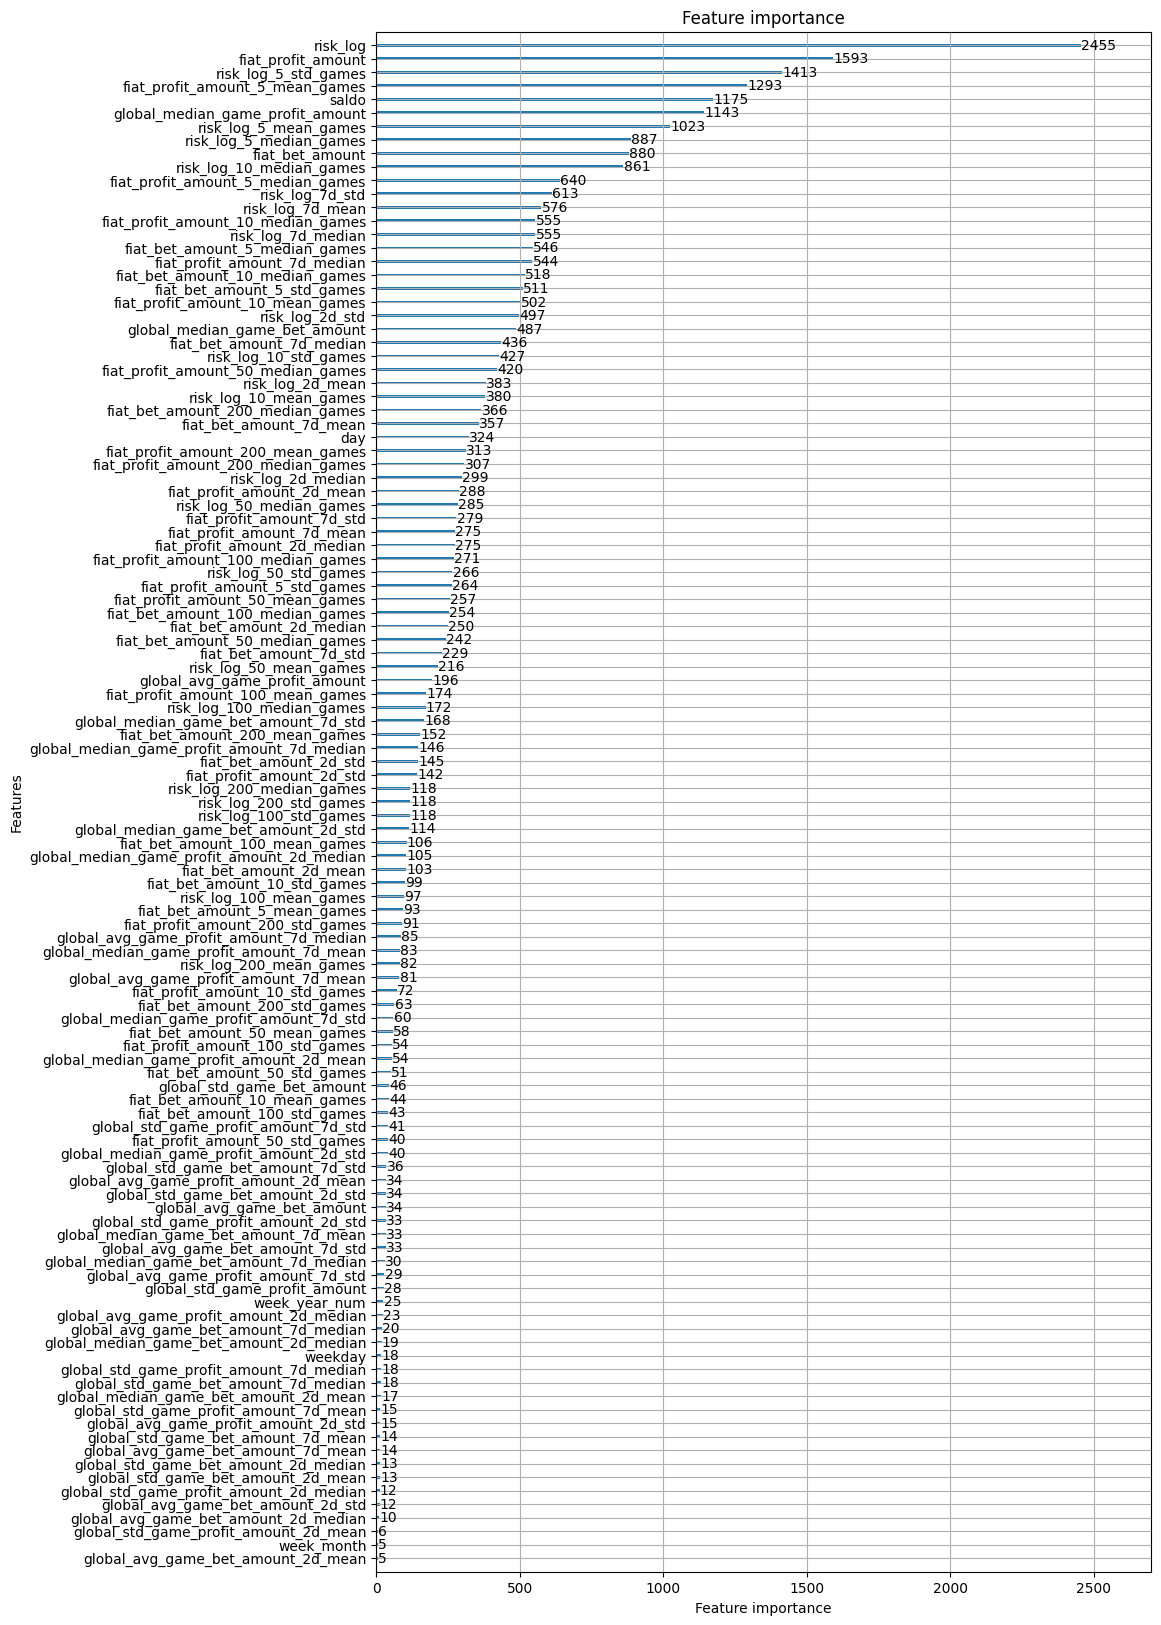

In [30]:

plot_importance(model, max_num_features=120, figsize=(10,20))
plt.show()


In [180]:
def plot_overall(y_true, y_pred, sample=None):
    s_true = pd.Series(y_true).reset_index(drop=True)
    s_pred = pd.Series(y_pred).reset_index(drop=True)
    df = pd.DataFrame({'y_true': s_true, 'y_pred': s_pred}).dropna()
    if sample and len(df) > sample:
        df = df.sample(sample, random_state=42)

    df['abs_err'] = (df['y_true'] - df['y_pred']).abs()
    mae = metrics.mean_absolute_error(df['y_true'], df['y_pred'])
    rmse = metrics.mean_squared_error(df['y_true'], df['y_pred'], squared=False)
    r2 = metrics.r2_score(df['y_true'], df['y_pred'])

    plt.figure(figsize=(8, 8))
    sc = plt.scatter(df['y_true'], df['y_pred'], c=df['abs_err'],
                     cmap='viridis', alpha=0.6, s=12, edgecolors='none')
    a = min(df['y_true'].min(), df['y_pred'].min())
    b = max(df['y_true'].max(), df['y_pred'].max())
    plt.plot([a, b], [a, b], 'k--', lw=1)
    cb = plt.colorbar(sc, pad=0.01); cb.set_label('|erro|')
    plt.xlabel('y_true'); plt.ylabel('y_pred')
    plt.title(f'Desempenho geral | MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}')
    plt.tight_layout(); plt.show()



c:\Users\mathe\repos\tcc\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


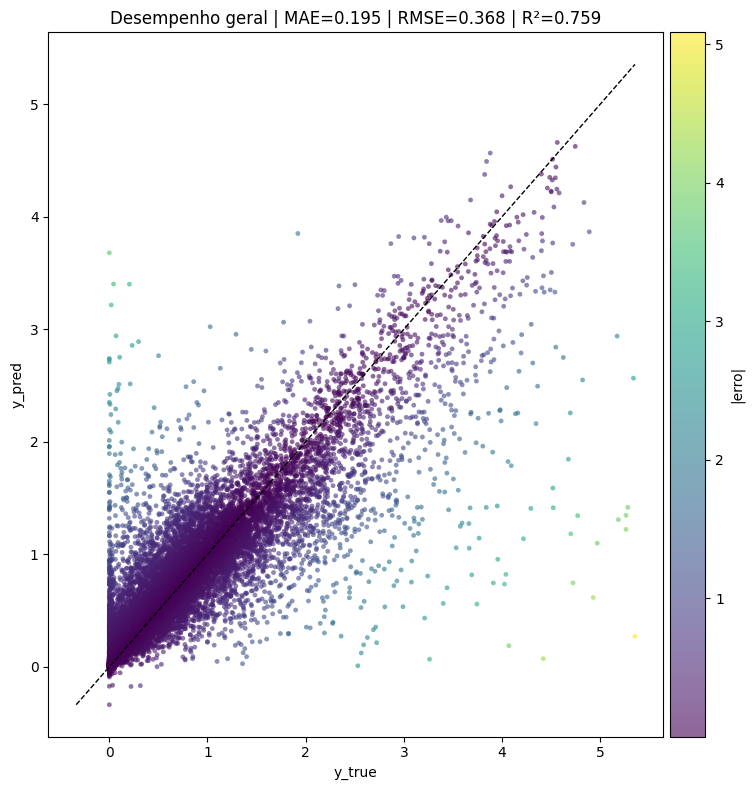

In [181]:
plot_overall(y_test, y_pred, sample=20000)  


In [32]:
def plot_selected_bets(user_bets):
    u = user_bets.copy()

    plots = [
        ("saldo", "Saldo acumulado", "red"),
        ("fiat_bet_amount", "Valor apostado", "green"),
        ("risk_log", "Risco (log)", "purple"),
    ]

    for col, title, line_color in plots:
        plt.figure(figsize=(20, 5))
        plt.plot(u["n_aposta"], u[col], marker="o", color=line_color)
        plt.axhline(y=0, color="gray", linewidth=0.5, linestyle="--")
        plt.xlabel("n_aposta")
        plt.ylabel(col)
        plt.title(f"{title} ao longo das apostas (n={len(u)})")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


In [35]:
df_small = df[['user_id','risk_log','game_id','saldo']].copy()
out = (
    df_small.groupby('user_id', sort=False)
            .agg(avg_risk=('risk_log','mean'),
                 game_count=('game_id','nunique'),
                 saldo=('saldo','sum'))
            .reset_index()
)
out.head()


C:\Users\mathe\AppData\Local\Temp\ipykernel_29188\1806743928.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_small.groupby('user_id', sort=False)


,user_id,avg_risk,game_count,saldo
0,55541,0.982904,1369,468.249481
1,56602,0.393502,62153,454173.000000
2,78531,0.356779,479,-450.215393
3,81128,0.725510,70612,3031.581543
4,109313,0.802285,1533,-5.689465


In [36]:
out.sort_values('avg_risk')


,user_id,avg_risk,game_count,saldo
15026,1455307,0.001087,741,0.001530
9705,1016819,0.005179,288,4.813673
20461,1232934,0.005303,463,0.804410
16089,1457891,0.005930,183,-1.000489
1423,135012,0.006565,239,-60.222683
...,...,...,...,...
32097,1503449,NaN,0,0.000000
32098,1503461,NaN,0,0.000000
32099,1503501,NaN,0,0.000000
32100,1503542,NaN,0,0.000000


In [69]:
# valid_players = out[(out['game_count'] > 900) & (out['game_count'] < 1100)].sort_values('avg_risk')
out[out['avg_risk']>1.00].sort_values('avg_risk')


,user_id,avg_risk,game_count,saldo
22253,1479147,1.000005,59,-2.177893
24973,1271542,1.000041,55,-0.335939
890,1431031,1.000079,401,1140.203979
2788,947166,1.000119,61,3753.392334
20777,181847,1.000403,13,0.253833
...,...,...,...,...
11798,1445920,4.635707,6,0.005273
7335,788789,4.653336,16,-0.004433
23480,1482212,4.872921,3,-0.001830
12111,1440462,5.045113,28,-2.616935


In [ ]:
# meta_test = meta.loc[X_test.index].copy()


In [68]:
out[out['user_id']==1281281]


,user_id,avg_risk,game_count,saldo
916,1281281,1.064832,5021,778009.0


In [49]:
train_meta = meta.loc[X_train.index].copy()

train = pd.DataFrame({
    "predicted": False,
    "risk": y_train,
    "risk_pred": y_train,
    "user_id": train_meta["user_id"],
    "bet_id": train_meta["bet_id"]
})#.sort_values("bet_id")


In [50]:
test_meta = meta.loc[X_test.index].copy()

test = pd.DataFrame({
    "predicted":True,
    "risk": y_test,
    "risk_pred": y_pred,
    "user_id": test_meta["user_id"],
    "bet_id": test_meta["bet_id"]
})

test.head()


,predicted,risk,risk_pred,user_id,bet_id
index,,,,,
8608638,True,0.162162,0.091113,1122678,220665052
19911999,True,0.197822,0.182162,1377869,233336556
17001866,True,0.243744,0.368983,1464014,230124713
17211269,True,0.402226,0.301870,415790,230379980
11611644,True,0.239877,0.327979,1449407,224119766


In [51]:
df_final = pd.concat([train,test]).sort_values("bet_id")


In [61]:
df_final.columns


Index(['predicted', 'risk', 'risk_pred', 'user_id', 'bet_id'], dtype='object')

In [52]:
df_final.head(100)


,predicted,risk,risk_pred,user_id,bet_id
index,,,,,
98,False,0.072636,0.072636,1264181,12148530
51,False,4.943514,4.943514,1032341,12148531
68,False,1.085189,1.085189,1179800,12148532
80,False,2.002201,2.002201,1205760,12148533
143,False,0.224907,0.224907,1365445,12148534
...,...,...,...,...,...
622,False,0.180042,0.180042,1276963,12148630
747,False,0.690530,0.690530,1430942,12148631
600,False,1.586092,1.586092,1243927,12148632


In [65]:
def plot_user_series(df, user_id, max_points=100, smooth_window=1):
    u = df[df["user_id"] == user_id].copy()
    if u.empty:
        return

    if len(u) > max_points:
        idx = np.linspace(0, len(u) - 1, max_points).astype(int)
        u = u.iloc[idx]

    win = min(smooth_window, max(1, len(u) // 5))
    risk_s = u["risk"].rolling(win, center=True, min_periods=1).mean()
    risk_pred_s = u["risk_pred"].rolling(win, center=True, min_periods=1).mean()

    plt.figure(figsize=(20, 6))
    plt.plot(range(len(u['bet_id'])), risk_pred_s, label="risk_pred", linewidth=1.5)
    plt.plot(range(len(u['bet_id'])), risk_s, label="risk", linewidth=1.5)
    plt.xlabel("bet_id")
    plt.ylabel("risk")
    plt.title(f"Usuário {user_id} | original size = {len(u)} | max_points = {max_points} | smooth_window = {smooth_window}")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# def plot_user_series(y_true, y_pred, meta_test, user_id, bets=None, max_points=100, smooth_window=1):
#     df = pd.DataFrame({
#         "y_true": y_true,
#         "y_pred": y_pred,
#         "user_id": meta_test["user_id"],
#         "bet_id": meta_test["bet_id"]
#     }).sort_values("bet_id")

#     if bets is not None and len(bets) > 0:
#         df = df[df["bet_id"].isin(bets)]

#     u = df[df["user_id"] == user_id].copy()
#     if u.empty:
#         return

#     mae_u = (u["y_true"] - u["y_pred"]).abs().mean()

#     if len(u) > max_points:
#         idx = np.linspace(0, len(u) - 1, max_points).astype(int)
#         u = u.iloc[idx]

#     win = min(smooth_window, max(1, len(u) // 5))
#     y_true_s = u["y_true"].rolling(win, center=True, min_periods=1).mean()
#     y_pred_s = u["y_pred"].rolling(win, center=True, min_periods=1).mean()

#     plt.figure(figsize=(20, 6))
#     plt.plot(range(len(u['bet_id'])), y_true_s, label="y_true", linewidth=1.5)
#     plt.plot(range(len(u['bet_id'])), y_pred_s, label="y_pred", linewidth=1.5)
#     plt.xlabel("bet_id")
#     plt.ylabel("risk")
#     plt.title(f"Usuário {user_id} | original size = {len(bets)} max_points = {max_points} | smooth_window = {smooth_window} | MAE = {mae_u:.3f}")
#     plt.grid(True, linestyle="--", alpha=0.3)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


def plot_user():
    pass


In [ ]:
def plot_user(uid, start = None,end = None):
    size = len(meta_test[meta_test['user_id']==uid])
    
    if start is None:
        start = 0
    if end is None:
        end = size

    bets_list = meta_test[meta_test['user_id']==uid]['bet_id'].unique().tolist()[start:end]
    
    if len(bets_list) >= size:
          start_idx = random.randint(0, len(bets_list) - size)
          selected_bets = bets_list[start_idx:start_idx + size]
    else:
          selected_bets = bets_list
          
    plot_user_series(y_test, y_pred, meta_test, uid, selected_bets, max_points=10000, smooth_window=1)
    
    user_bets = df[df['bet_id'].isin(selected_bets)]
    plot_selected_bets(user_bets)
    
    user_bets


In [158]:
def plot_user_series(
    df, 
    user_id, 
    max_points=100, 
    smooth_window=1, 
    downsample_method="uniform",   # "uniform" | "random_block" | "none"
    random_state=42,
    marker=True
):
    u = df[df["user_id"] == user_id].copy()
        
    original_n = len(u)
        
    win = max(1, min(smooth_window, max(1, len(u)//5)))
    risk_full      = u["risk"].rolling(win, center=True, min_periods=1).mean().to_numpy()
    risk_pred_full = u["risk_pred"].rolling(win, center=True, min_periods=1).mean().to_numpy()
    
    
    method_used = "none"
    if downsample_method == "uniform" and len(u) > max_points:
          idx = np.linspace(0, len(u) - 1, max_points).astype(int)
          u = u.iloc[idx]
          risk      = risk_full[idx]
          risk_pred = risk_pred_full[idx]
          method_used = f"uniform ({max_points})"
    
    elif downsample_method == "random_block" and len(u) > max_points:
          rng = np.random.RandomState(random_state)
          start = rng.randint(0, len(u) - max_points + 1)
          idx = np.arange(start, start + max_points)
          u = u.iloc[idx]
          risk      = risk_full[idx]
          risk_pred = risk_pred_full[idx]
          method_used = f"random block ({max_points}, seed={random_state})"
    
    else:
          risk      = risk_full
          risk_pred = risk_pred_full
    

    x = np.arange(len(u))
    is_pred = u["predicted"].astype(bool).to_numpy() if "predicted" in u.columns else np.zeros(len(u), bool)
    
    
    resid = risk_pred - risk
    mae_test = float(np.mean(np.abs(resid[is_pred]))) if is_pred.any() else np.nan
    mae_all = np.mean(np.abs(df.loc[df.predicted == True, "risk_pred"] 
                             - df.loc[df.predicted == True, "risk"]))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 9), sharex=True, height_ratios=[2, 1])

    ax1.plot(x, risk_pred, label="Predicted risk",   color="#ff7f0e", linewidth=1.8)   # laranja
    ax1.plot(x, risk,      label="True risk",      color="#1f77b4", linewidth=1.8)   # azul
    
    ax1.fill_between(x, risk, risk_pred, alpha=0.25, color="gray")

    if marker:
      ax1.scatter(
          x[is_pred], risk_pred[is_pred],
          color="#ff7f0e", marker="x", s=90, linewidth=2.0,
          label="Test predicted points"
      )
      
      ax1.scatter(
          x[is_pred], risk[is_pred],
          color="#1f77b4", marker="o", s=70, edgecolor="black", linewidth=0.7,
          label="Test true points"
      )

    # ax1.xlabel("bet_id (ordem)")
    # ax1.ylabel("risk")
    
    title = f"Risk Analysis — User {user_id} | total bets={original_n}"

    if original_n != len(u):
        title += f" | downsampled to {len(u)} bets"
    if method_used != "none":
        title += f" | downsampling={method_used}"
    if smooth_window > 1:
        title += f" | smoothing={smooth_window}"
    ax1.set_title(title)
    
    ax1.grid(True, linestyle="--", alpha=0.3)
    ax1.legend()
    
    ax2.plot(x, resid, linewidth=1.5)
    ax2.axhline(0.0, linewidth=1.2)
    if marker:
      ax2.scatter(x[is_pred], resid[is_pred], marker="x", s=70, linewidth=2.0)

    ax2.set_xlabel("Bet order ")
    ax2.set_ylabel("Residuals")
    subtitle = f"Global MAE={mae_all:.4f}"
    if is_pred.any():
        subtitle += f" | User MAE ={mae_test:.4f}"
    ax2.set_title(subtitle)
    ax2.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()


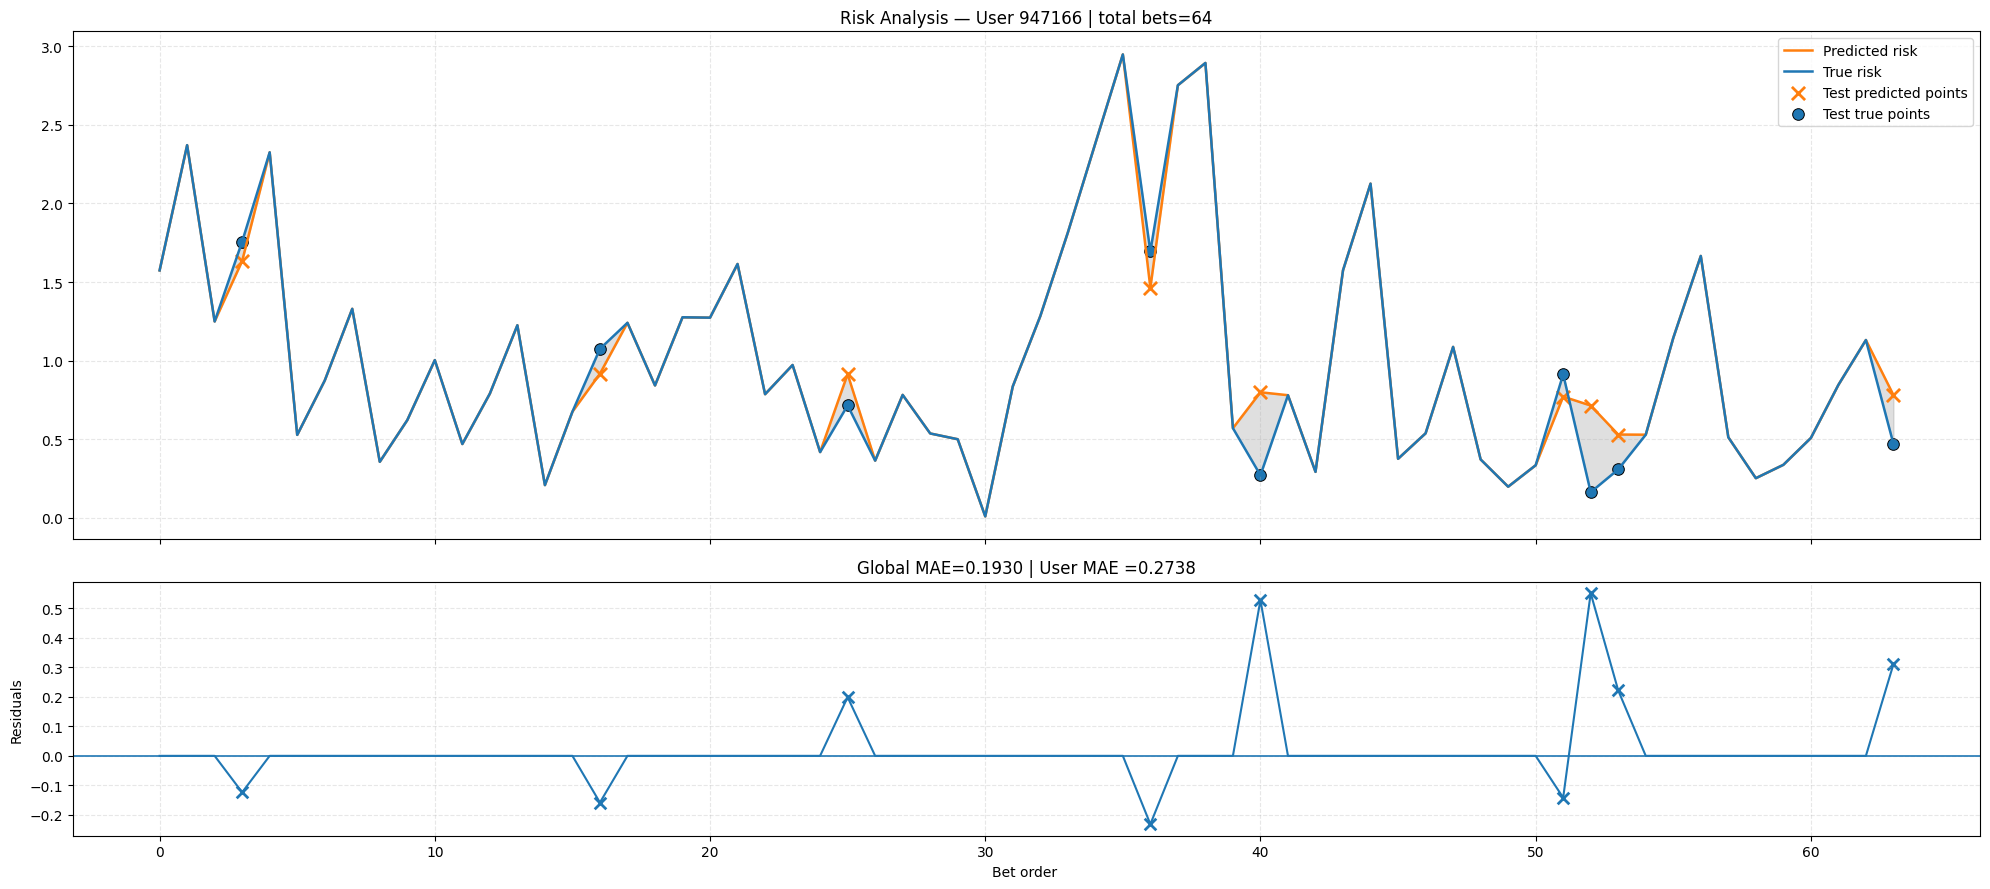

In [161]:
plot_user_series(df_final,947166) 


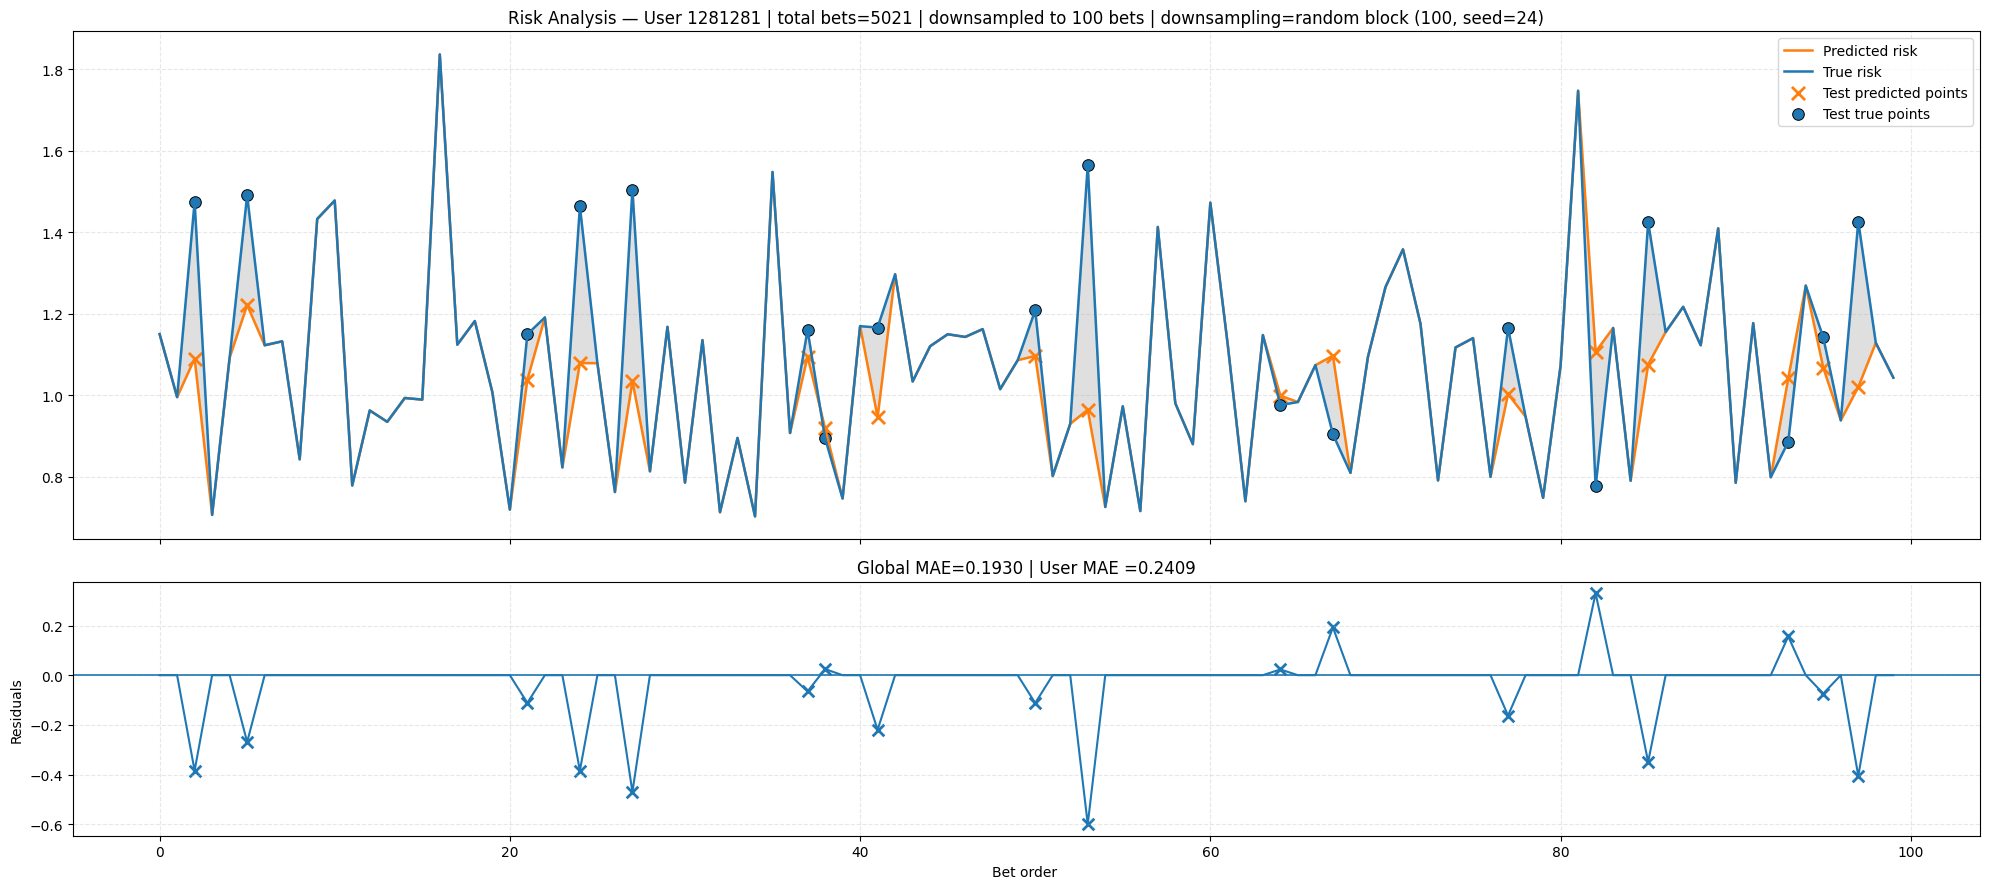

In [160]:
plot_user_series(df_final,1281281, max_points=100, downsample_method="random_block", random_state=24)


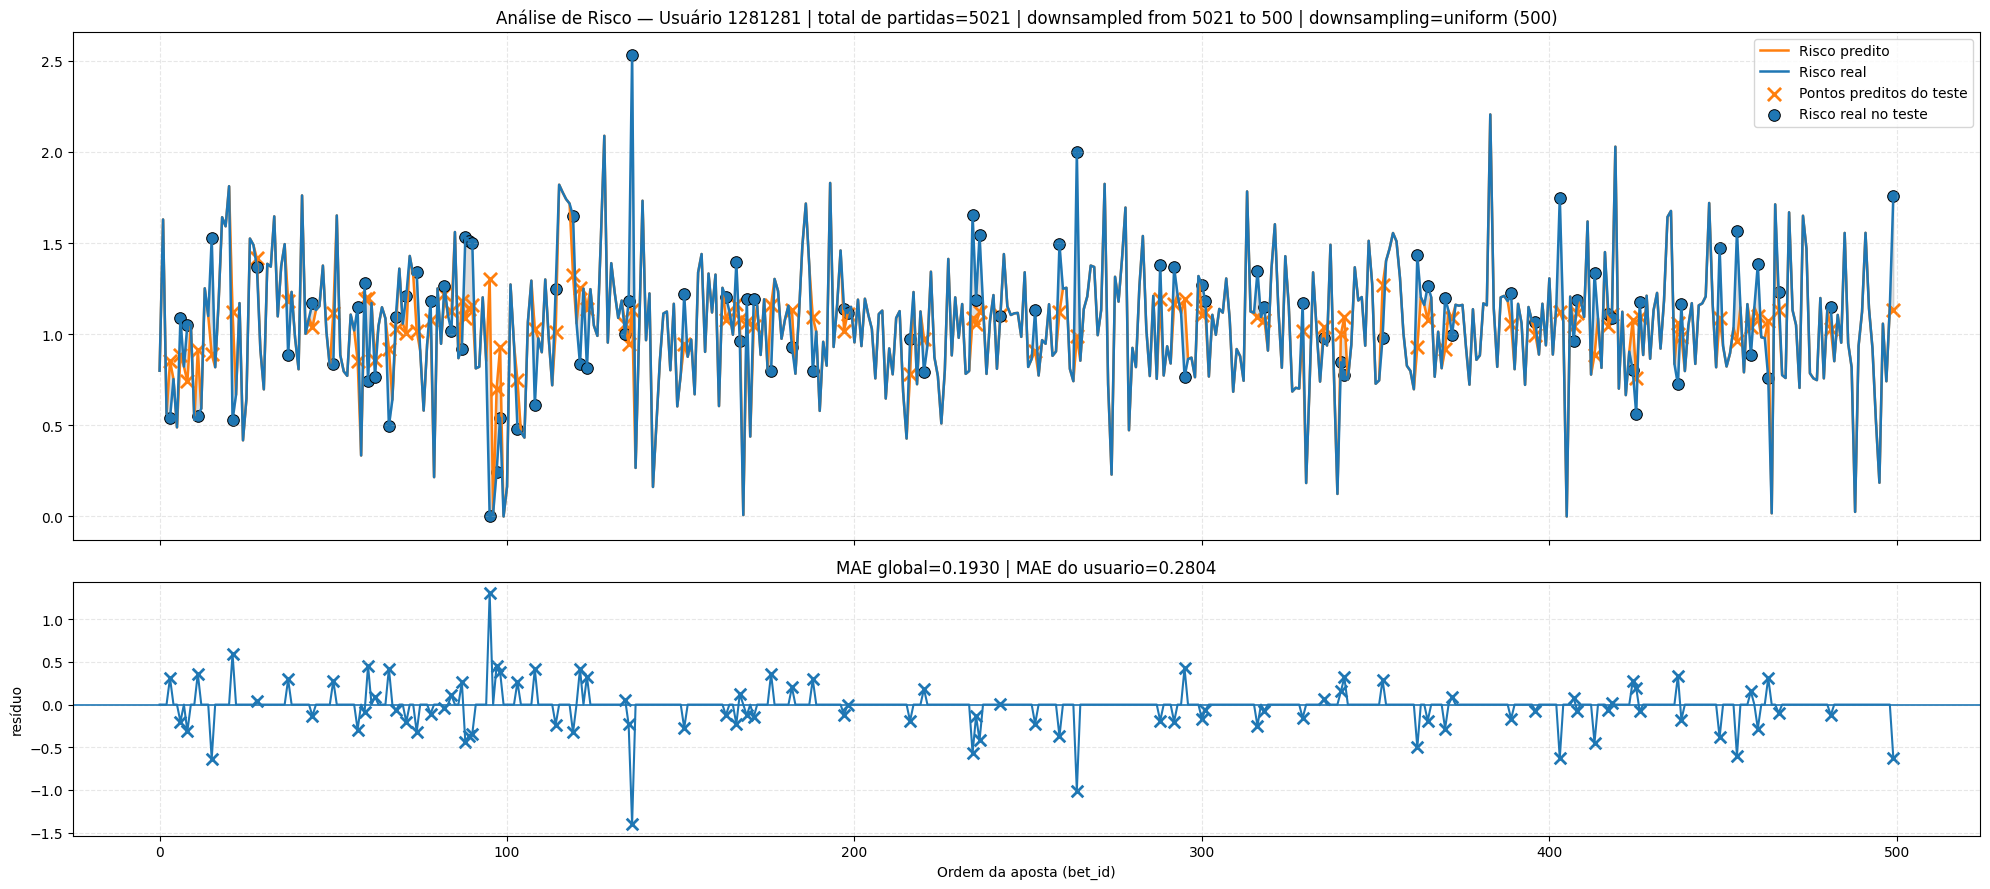

In [143]:
plot_user_series(df_final,1281281, max_points=500, smooth_window=1)


In [188]:
def plot_user_profile(
    df,
    user_id,
    max_points=300,
    smooth_window=1,
    downsample_method="uniform",
    random_state=42
):
    u = df[df["user_id"] == user_id].copy()

    original_n = len(u)

    win = max(1, min(smooth_window, max(1, len(u) // 5)))

    def smooth(arr):
        return arr.rolling(win, center=True, min_periods=1).mean().to_numpy()

    metrics = {
        "saldo": ("Saldo acumulado", "red"),
        "fiat_bet_amount": ("Valor apostado", "green"),
        "risk_log": ("Risco (log)", "purple"),
    }

    def apply_downsample(arr, u_df):
        n = len(arr)
        if downsample_method == "uniform" and n > max_points:
            idx = np.linspace(0, n - 1, max_points).astype(int)
        elif downsample_method == "random_block" and n > max_points:
            rng = np.random.RandomState(random_state)
            start = rng.randint(0, n - max_points + 1)
            idx = np.arange(start, start + max_points)
        else:
            idx = np.arange(n)
        return arr[idx], u_df.iloc[idx], idx


    for col, (title, color) in metrics.items():

        arr_full = smooth(u[col])
        arr, u_ds, idx = apply_downsample(arr_full, u)

        x = u_ds["n_aposta"].to_numpy()

        plt.figure(figsize=(20, 5))
        plt.plot(x, arr, color=color, linewidth=1.8)

        plt.axhline(y=0, color="gray", linewidth=0.6, linestyle="--")
        plt.grid(True, linestyle="--", alpha=0.4)

        ttl = f"{title} ao longo das apostas | usuário {user_id}"
        ttl += f" | total={original_n}"
        if len(arr) != original_n:
            ttl += f" | downsample={len(arr)} ({downsample_method})"
        if smooth_window > 1:
            ttl += f" | smooth={win}"

        plt.title(ttl)
        plt.xlabel("n_aposta")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

    if "day" in u.columns:
        u_day = u.copy()

        agg = u_day.groupby("day").agg({
            "fiat_bet_amount": "mean",
            "saldo": "mean",
            "risk_log": "mean",
        }).reset_index()

        # suavização leve opcional
        agg_smooth = agg.copy()
        for col in ["fiat_bet_amount", "saldo", "risk_log"]:
            agg_smooth[col] = agg_smooth[col].rolling(win, center=True, min_periods=1).mean()

        # plot risco médio por dia
        plt.figure(figsize=(20,5))
        plt.plot(agg["day"], agg_smooth["risk_log"], color="purple", linewidth=2)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.title(f"Risco médio por dia — Usuário {user_id}")
        plt.xlabel("Dia")
        plt.ylabel("Risco médio (log)")
        plt.tight_layout()
        plt.show()

        # plot valor médio apostado por dia
        plt.figure(figsize=(20,5))
        plt.plot(agg["day"], agg_smooth["fiat_bet_amount"], color="green", linewidth=2)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.title(f"Valor médio apostado por dia — Usuário {user_id}")
        plt.xlabel("Dia")
        plt.ylabel("Média de aposta")
        plt.tight_layout()
        plt.show()

        # plot saldo médio por dia
        plt.figure(figsize=(20,5))
        plt.plot(agg["day"], agg_smooth["saldo"], color="red", linewidth=2)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.title(f"Saldo médio por dia — Usuário {user_id}")
        plt.xlabel("Dia")
        plt.ylabel("Saldo médio")
        plt.tight_layout()
        plt.show()


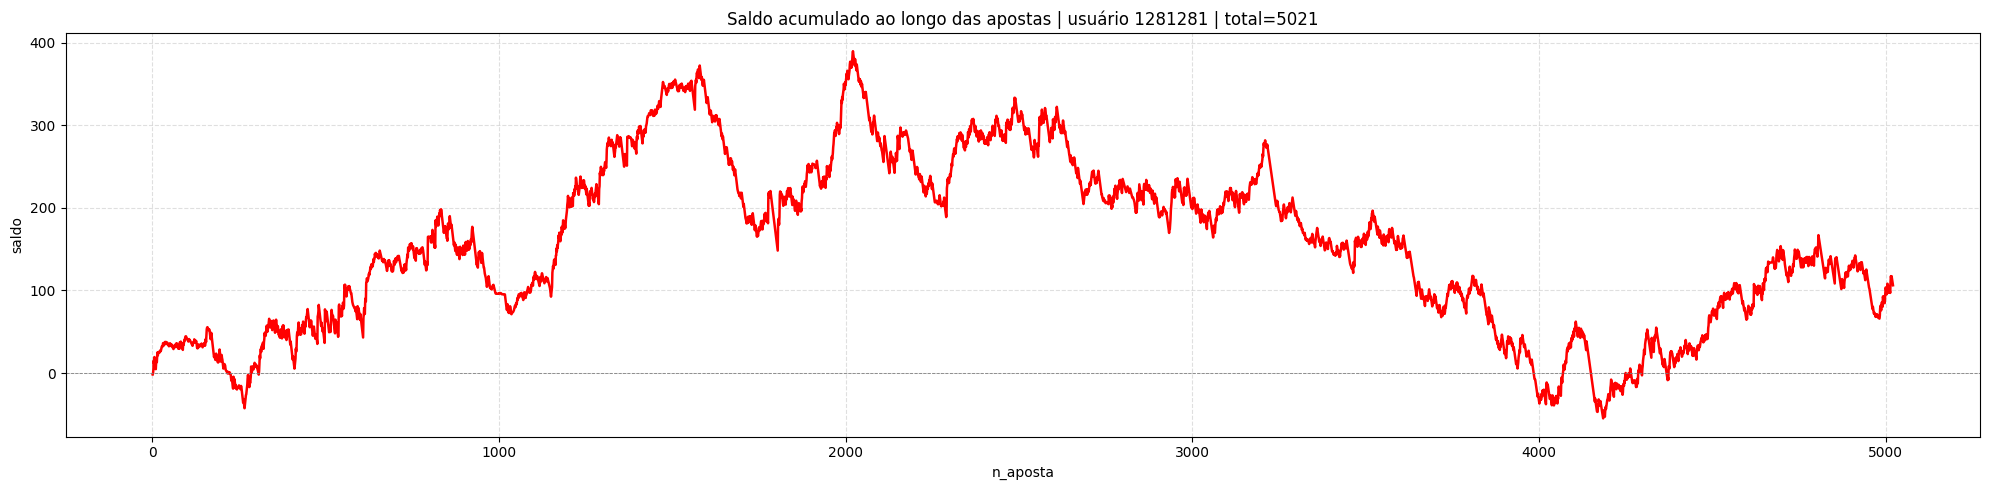

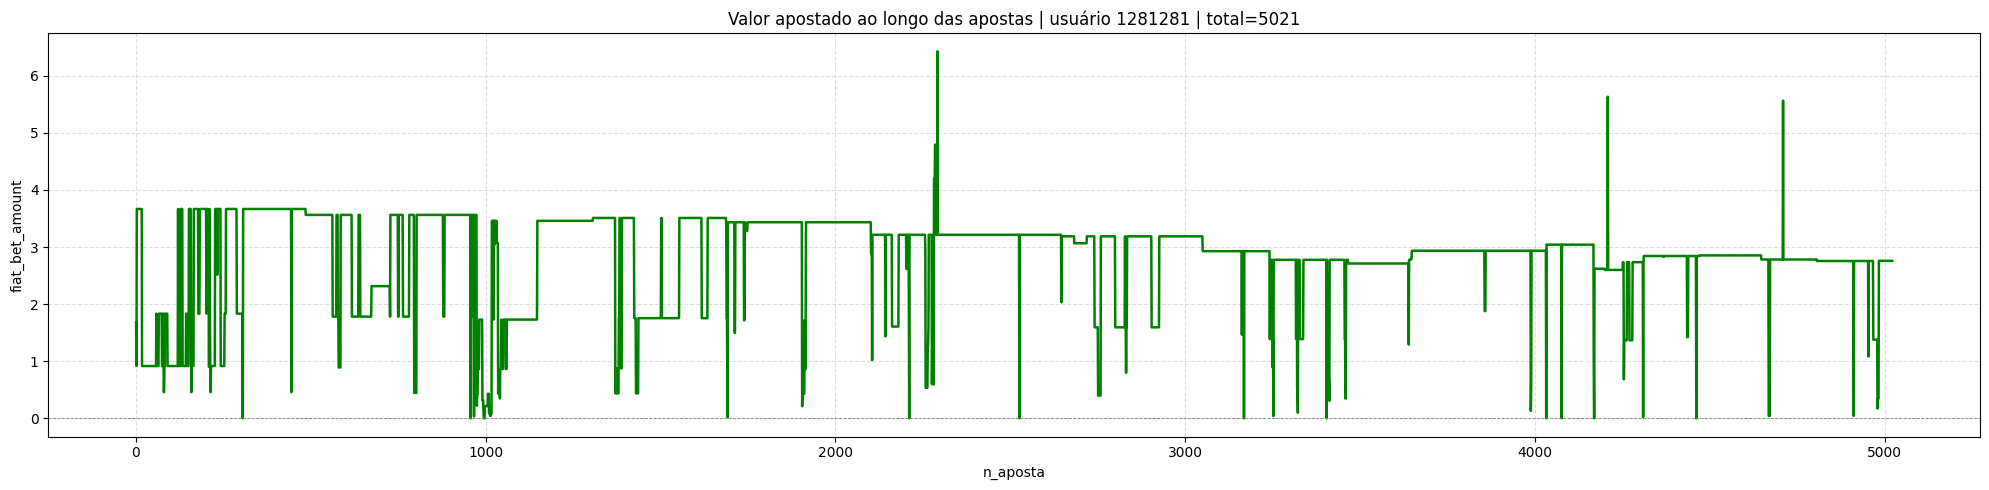

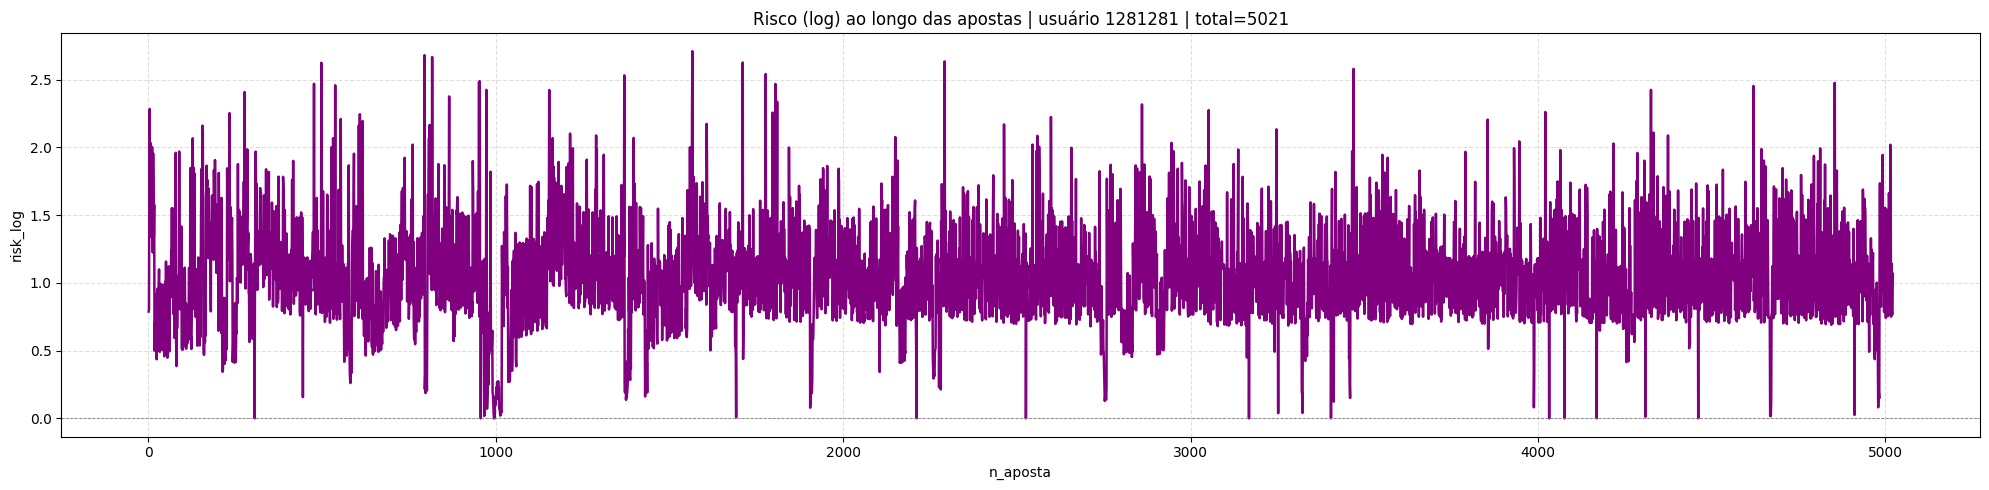

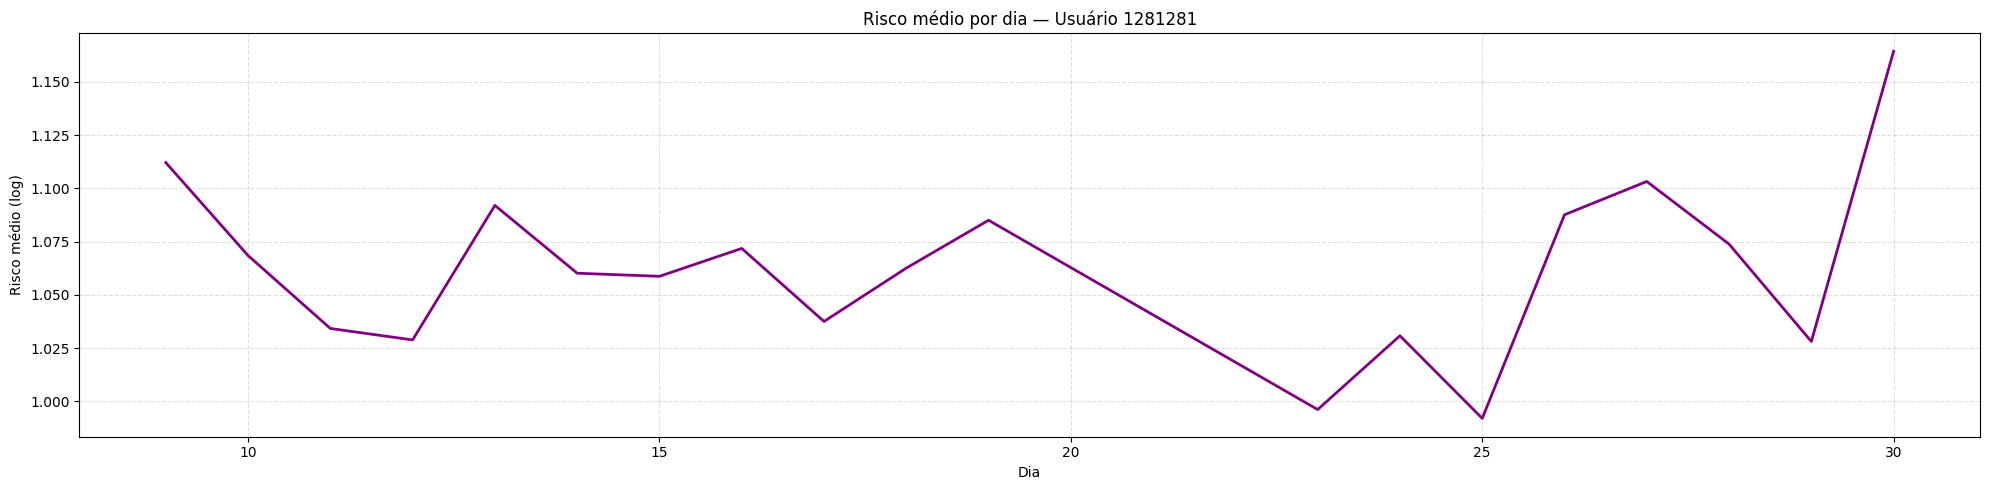

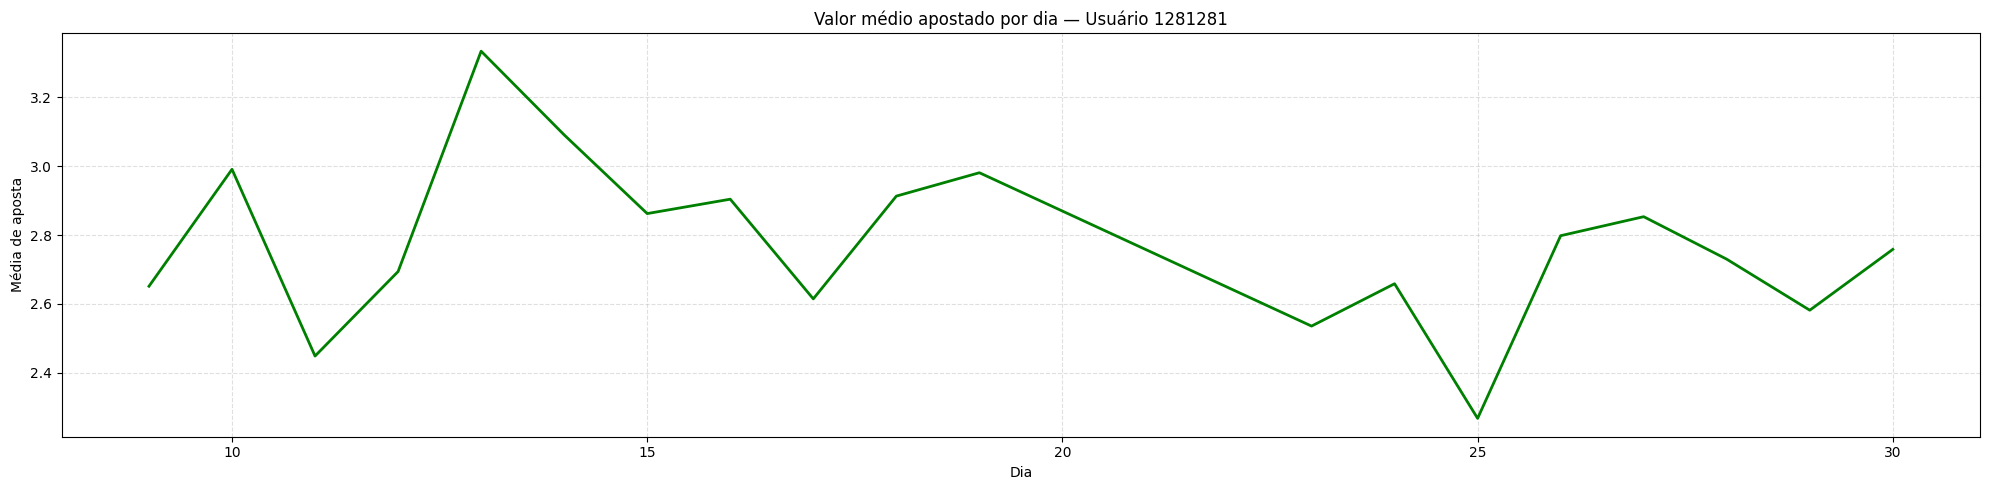

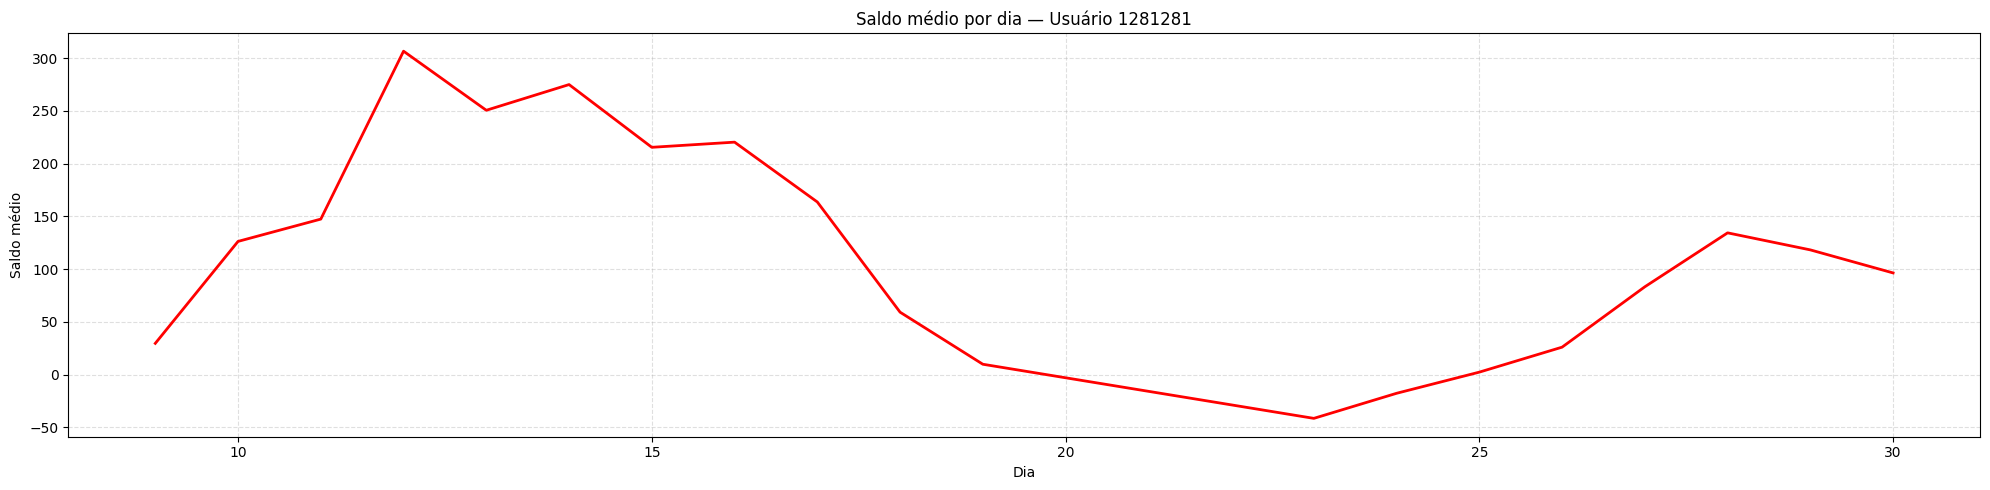

In [189]:
plot_user_profile(df, 1281281, max_points=10000)


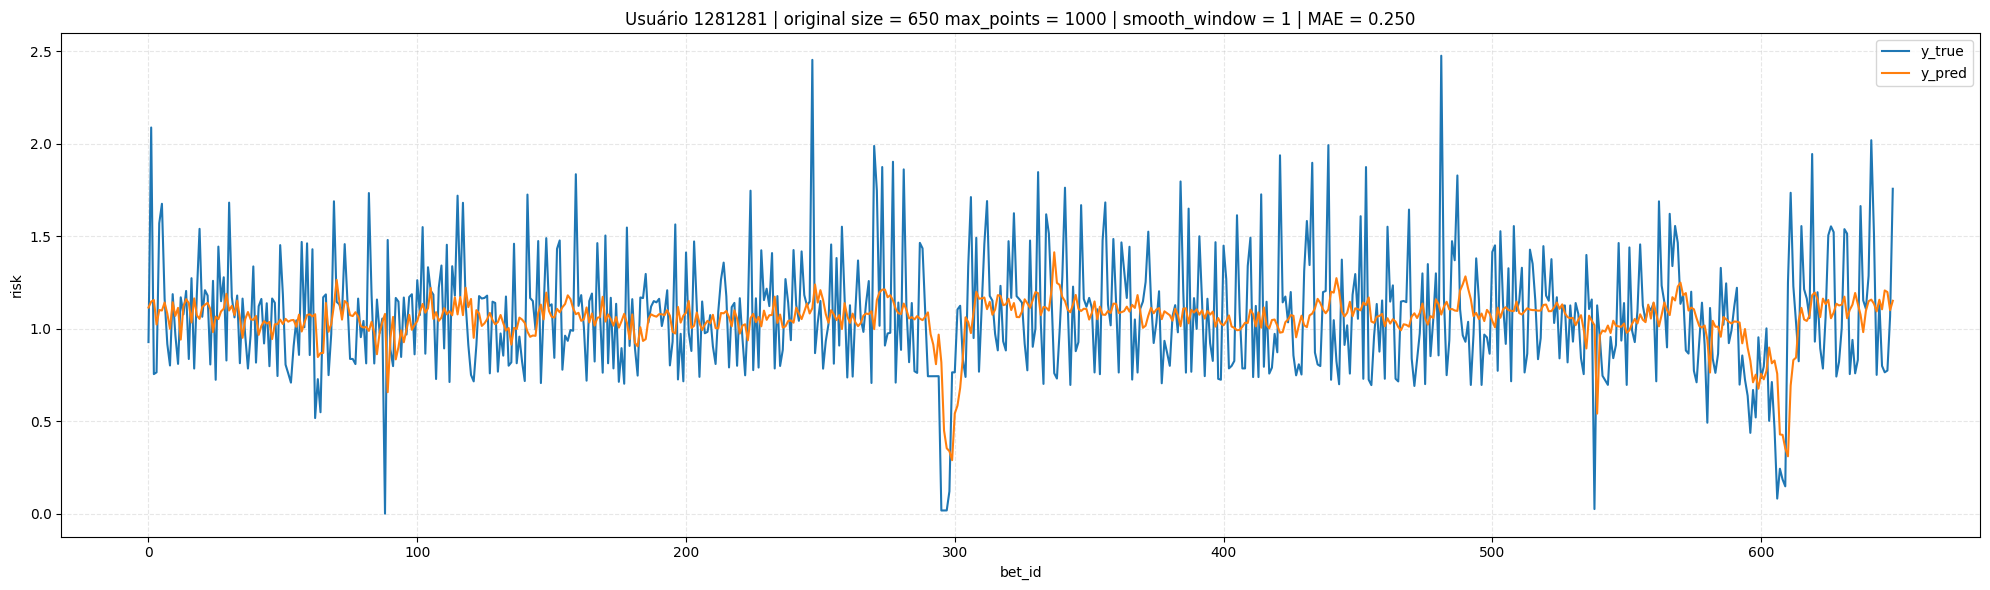

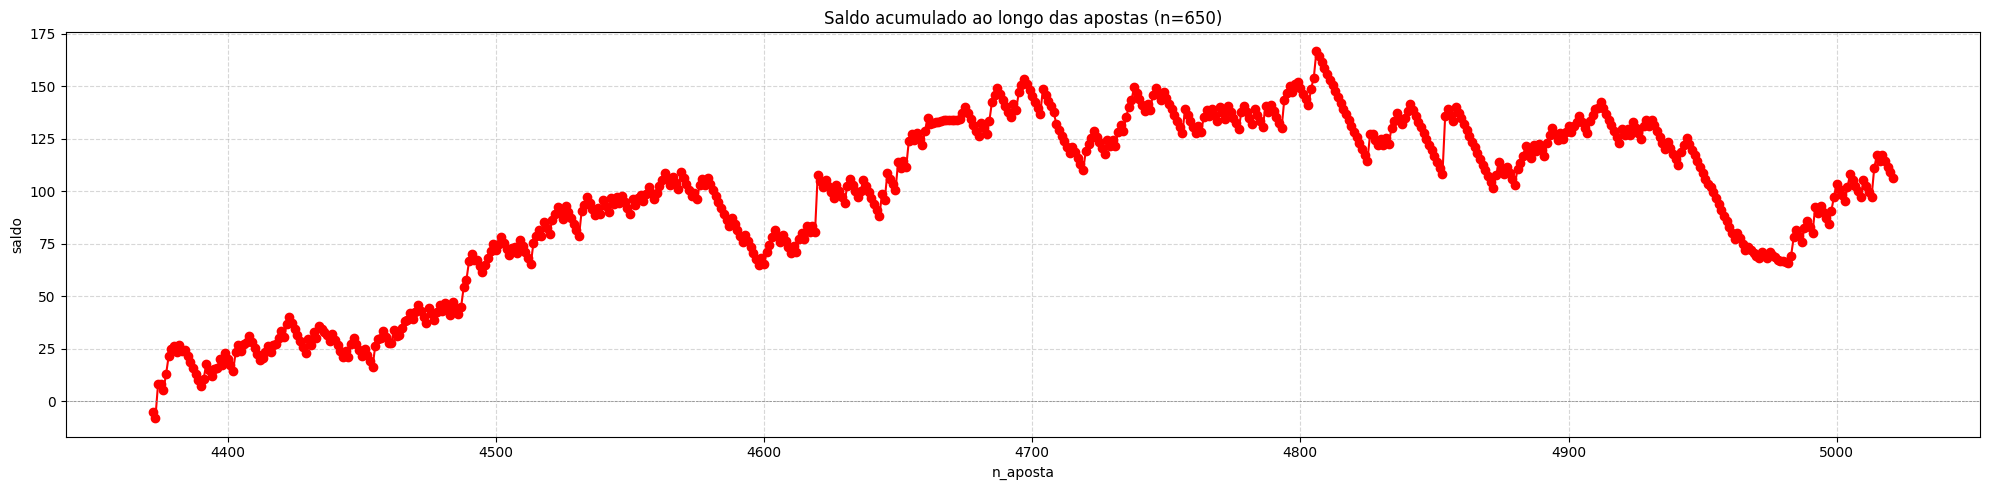

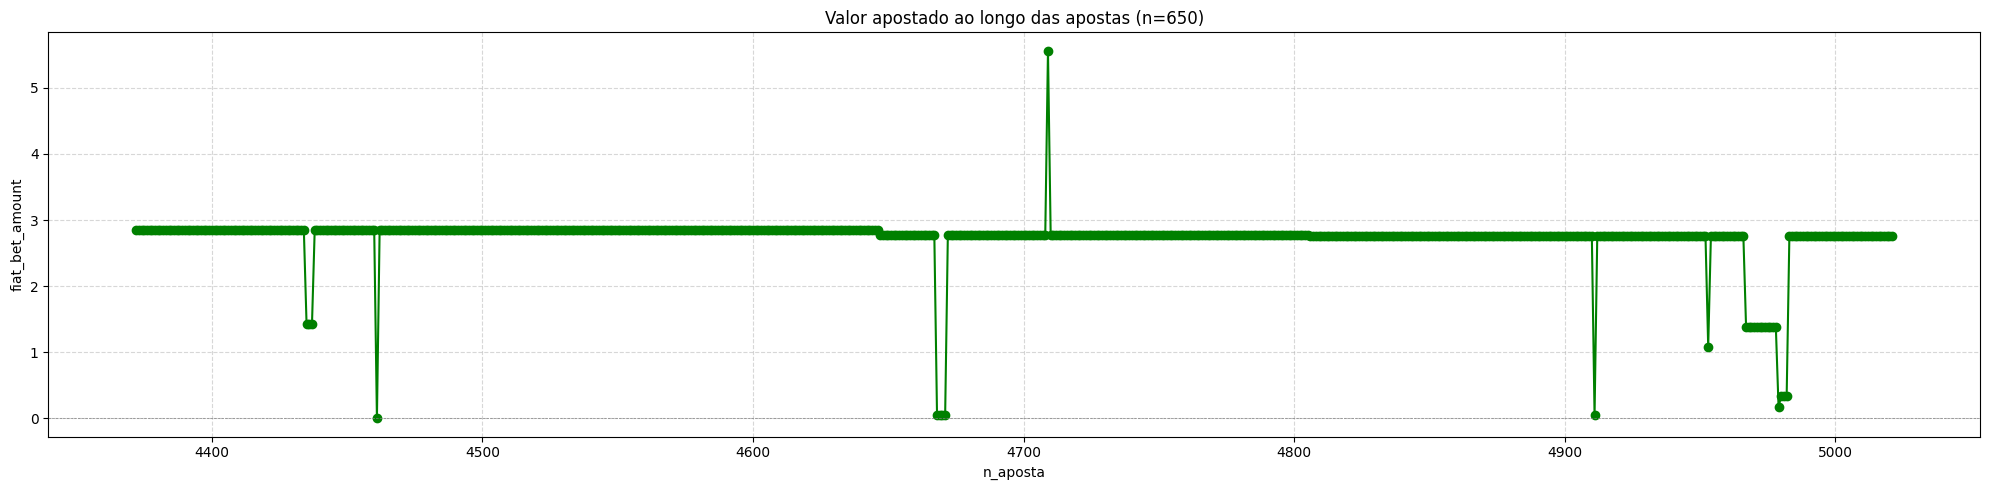

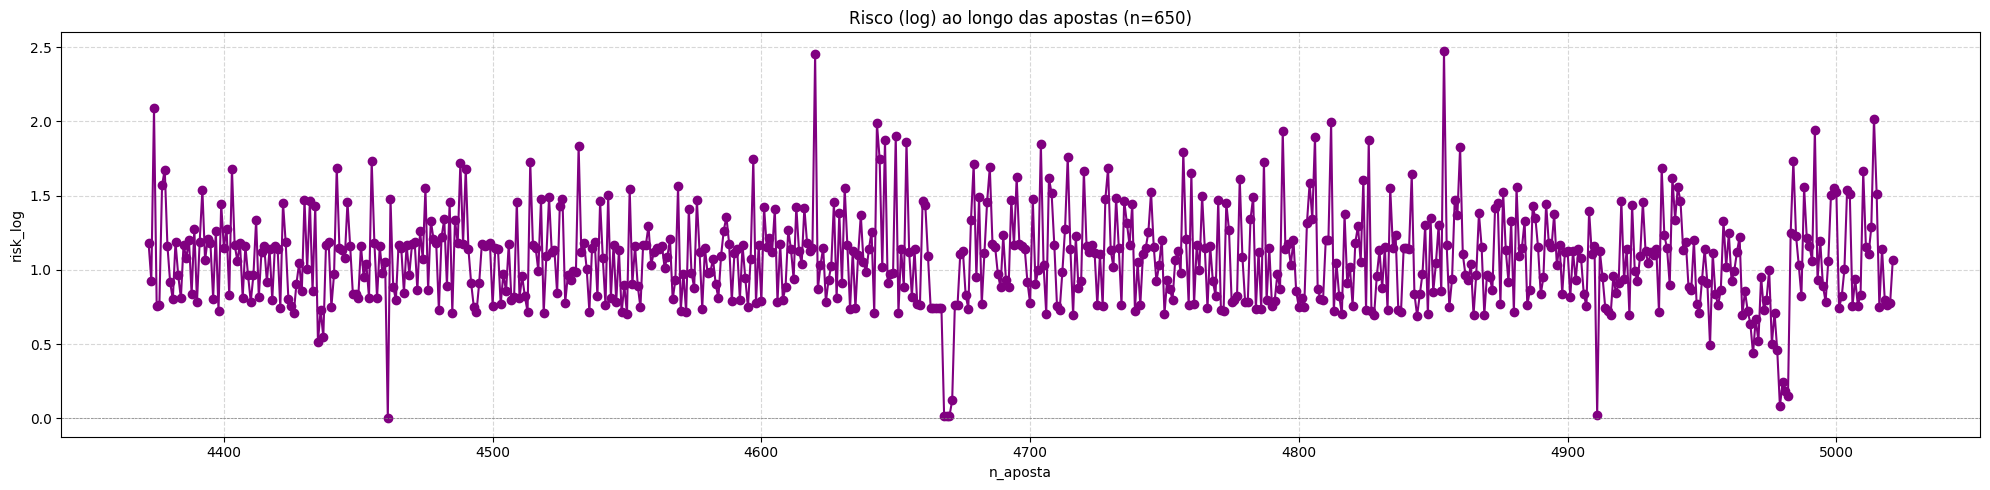

In [35]:
uid = 1281281

size = len(meta_test[meta_test['user_id']==uid])

bets_list = meta_test[meta_test['user_id']==uid]['bet_id'].unique().tolist()

if len(bets_list) >= size:
    start_idx = random.randint(0, len(bets_list) - size)
    selected_bets = bets_list[start_idx:start_idx + size]
else:
    selected_bets = bets_list
    
plot_user_series(y_test, y_pred, meta_test, uid, selected_bets, max_points=1000, smooth_window=1)

user_bets = df[df['bet_id'].isin(selected_bets)]
plot_selected_bets(user_bets)


In [33]:
# plot_user_series(y_test, y_pred, meta_test, uid, selected_bets, max_points=1000, smooth_window=1)
#plot_user_series_low(y_test, y_pred, meta_test, uid, selected_bets)
#0.430


In [ ]:
user_bets = df[df['bet_id'].isin(selected_bets)]
plot_selected_bets(user_bets)


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,timestamp,saldo,n_aposta,risk_log,global_avg_game_bet_amount,...,risk_log_50_mean_games,risk_log_50_std_games,risk_log_50_median_games,risk_log_100_mean_games,risk_log_100_std_games,risk_log_100_median_games,risk_log_200_mean_games,risk_log_200_std_games,risk_log_200_median_games,risk_next
index,,,,,,,,,,,,,,,,,,,,,
18743280,2886962,1281281,232082542,2.842824,3.212391,1601092804,-5.343428,4372,1.178119,0.246286,...,1.131435,0.360823,1.065896,1.113442,0.376585,1.076195,1.044355,0.343978,0.985924,0.928083
18743635,2886963,1281281,232082961,2.842824,-2.842824,1601092804,-8.186252,4373,0.928083,0.274470,...,1.124296,0.361254,1.060747,1.115353,0.375138,1.076195,1.045722,0.342963,0.985924,2.088738
18743985,2886964,1281281,232083399,2.842824,16.232525,1601092804,8.046273,4374,2.088738,0.379311,...,1.144764,0.385990,1.061319,1.128870,0.385575,1.095716,1.052730,0.349850,0.986682,0.754970
18744712,2886966,1281281,232084219,2.842824,0.198998,1601092804,8.245271,4375,0.754970,0.219358,...,1.111353,0.342745,1.046207,1.128750,0.385691,1.095716,1.052955,0.349644,0.986682,0.764540
18746177,2886970,1281281,232085803,2.842824,-2.842824,1601092804,5.402447,4376,0.764540,0.260466,...,1.111684,0.342395,1.046207,1.128825,0.385619,1.095716,1.052700,0.349836,0.986682,1.570824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23228698,2899698,1281281,236966054,2.758577,2.730991,1601438402,117.282669,5017,1.143819,7.715288,...,1.001774,0.451454,0.978215,1.031244,0.369151,1.012785,1.052683,0.346614,1.041071,0.799437
23231662,2899706,1281281,236969270,2.758577,-2.758577,1601438402,114.524094,5018,0.799437,7.378216,...,1.005007,0.449368,0.978215,1.030827,0.369392,1.012785,1.052117,0.346936,1.041071,0.764660
23232044,2899707,1281281,236969730,2.758577,-2.758577,1601438402,111.765518,5019,0.764660,7.581308,...,1.011558,0.443267,0.978215,1.029349,0.370165,1.012785,1.050847,0.347524,1.041071,0.774207


In [23]:
meta_test["user_id"].unique()


[1479496, 1479639, 1480113, 1481536, 1482280, ..., 363896, 1380934, 1183222, 1503516, 1503513]
Length: 11370
Categories (32102, uint32): [44, 46, 5588, 5977, ..., 1503513, 1503516, 1503542, 1503546]

In [24]:
mae = pd.DataFrame({
    "user_id": meta_test["user_id"],
    "y_true": y_test,
    "y_pred": y_pred
})
mae["abs_error"] = (mae["y_true"] - mae["y_pred"]).abs()

user_stats = (
    mae.groupby("user_id", as_index=False)
      .agg(
          mae=("abs_error", "mean"),
          avg_risk=("y_true", "mean"),
          std_risk=("y_true", "std"),
          avg_pred=("y_pred", "mean"),
          n_bets=("y_true", "count")
      )
)
user_stats = user_stats.dropna()
user_stats.head()


C:\Users\mathe\AppData\Local\Temp\ipykernel_32676\3867553993.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae.groupby("user_id", as_index=False)


,user_id,mae,avg_risk,std_risk,avg_pred,n_bets
0,44,0.041737,0.004770,0.006141,0.045564,13
2,5588,0.583176,1.029956,0.842232,0.994629,1238
3,5977,0.943433,2.528799,0.920115,2.046056,18
6,9699,0.127763,0.508598,0.650463,0.525836,1643
12,23074,0.450024,1.675823,0.514739,1.225799,2


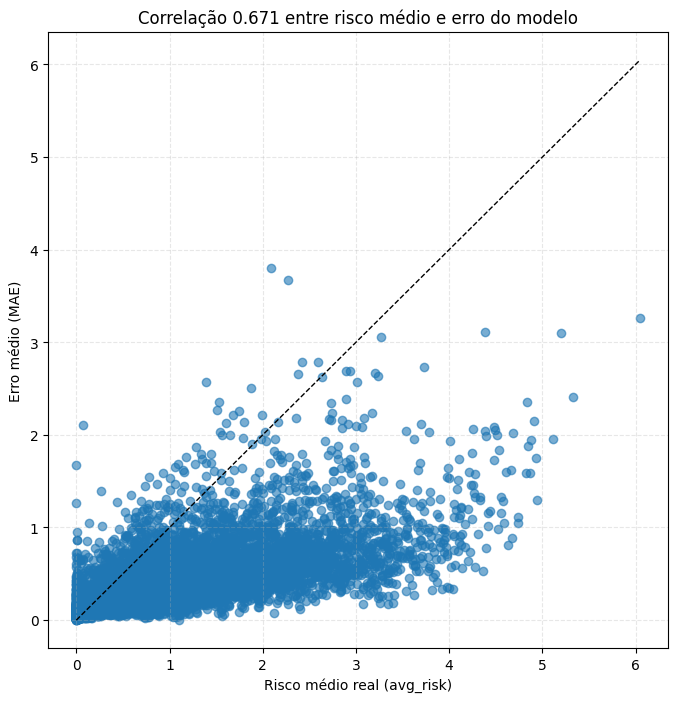

In [34]:
corr = user_stats[["avg_risk", "mae"]].corr().iloc[0, 1]
plt.figure(figsize=(8, 8))
plt.scatter(user_stats["avg_risk"], user_stats["mae"], alpha=0.6)
plt.xlabel("Risco médio real (avg_risk)")
plt.ylabel("Erro médio (MAE)")
a = min(user_stats['avg_risk'].min(), user_stats['mae'].min())
b = max(user_stats['avg_risk'].max(), user_stats['mae'].max())
plt.plot([a, b], [a, b], 'k--', lw=1)

plt.title(f"Correlação {corr:.3f} entre risco médio e erro do modelo")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


In [26]:
from pingouin import partial_corr
partial_corr(data=user_stats, x='avg_risk', y='mae', covar='std_risk')



,n,r,CI95%,p-val
pearson,10796,0.4768,"[0.46, 0.49]",0.0


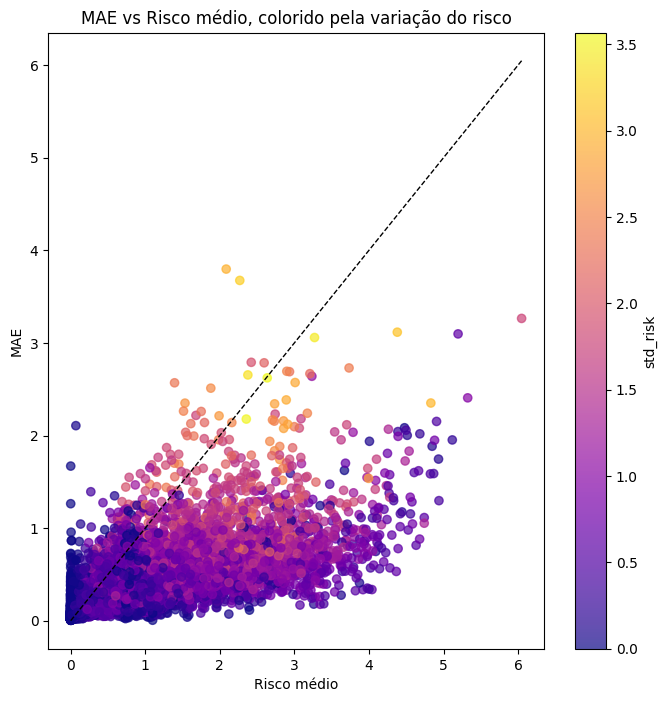

In [27]:
plt.figure(figsize=(8, 8))

plt.scatter(user_stats['avg_risk'], user_stats['mae'],
            c=user_stats['std_risk'], cmap='plasma', alpha=0.7)
a = min(user_stats['avg_risk'].min(), user_stats['mae'].min())
b = max(user_stats['avg_risk'].max(), user_stats['mae'].max())
plt.plot([a, b], [a, b], 'k--', lw=1)
plt.colorbar(label='std_risk')
plt.xlabel('Risco médio')
plt.ylabel('MAE')
plt.title('MAE vs Risco médio, colorido pela variação do risco')
plt.show()
